In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone, timedelta
from io import StringIO
import geohash2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")

# Extraction - PM25 - NowCast AQI

---

## Air Quality Index - AQI - Basics

### What is the U.S. Air Quality Index - AQI?

The U.S. AQI is EPA’s index for reporting air quality.

[AQI - Basics](https://www.airnow.gov/aqi/aqi-basics/)

[Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index - AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf)

| Using Table 5, find the two breakpoints that contain the concentration. | AQI for Ozone and Particle Pollution |
| --- | --- |
| <img src="breakpoints_aqi.png" alt="Breakpoints for the AQI" width="auto"/> | <img src="categories_aqi.png" alt="Categories for the AQI" width="auto"/> |


### Calculating the AQI

**How do I Calculate the AQI from pollutant concentration data?**

The AQI is the highest value calculated for each pollutan as follows:

    A. Identify the highest concentration among all of the monitors within each reporting area and truncate as follow:

<img src="pollutants.png" alt="Pollutants" width="auto"/>

    B. Using Table 5, find the two breakpoints tha contain the concentration.

    C. Using Equation 1, calculate the index

<img src="equation1.png" alt="Equation 1" width="auto"/>

    D. Round the index to the nearest integer


### Constants

In [2]:
# Levels of Concern
GOOD = 0
MODERATE = 1
UNHEALTHY_FOR_SENSITIVE_GROUPS = 2
UNHEALTHY = 3
VERY_UNHEALTHY = 4
HAZARDOUS = 5
# AQI Levels
AQI_LEVELS = (
    (GOOD, 'Good', [0, 50]), # 0 - 50
    (MODERATE, 'Moderate', [51, 100]), # 51 - 100
    (UNHEALTHY_FOR_SENSITIVE_GROUPS, 'Unhealthy for sensitive groups', [101, 150]), # 101 - 150
    (UNHEALTHY, 'Unhealthy', [151, 200]), # 151 - 200
    (VERY_UNHEALTHY, 'Very Unhealthy', [201, 300]), # 201 - 300
    (HAZARDOUS, 'Hazardous', [301, sys.maxsize]), # 301 - higher
)
# PM25 Breakpoints Values
PM25_BREAKPOINTS = (
    (GOOD, 'Good', [0.0, 12.0]), # 0.0 - 12.0, Good
    (MODERATE, 'Moderate', [12.1, 35.4]), # 12.1 - 35.4, Moderate
    (UNHEALTHY_FOR_SENSITIVE_GROUPS, 'Unhealthy for sensitive groups', [35.5, 55.4]), # 35.5 - 55.4, Unhealthy for sensitive groups
    (UNHEALTHY, 'Unhealthy', [55.5, 150.4]), # 55.5 - 150.4, Unhealthy
    (VERY_UNHEALTHY, 'Very Unhealthy', [150.5, 250.4]), # 150.5 - 250.4, Very Unhealthy
    (HAZARDOUS, 'Hazardous', [250.5, 350.4]), # 250.5 - 350.4, Hazardous
    (HAZARDOUS, 'Hazardous', [350.5, 500.4]), # 350.5 - 500.4, Hazardous
)
# Max PM25 Value
MAX_PM25_VALUE = 500.5

### Equation 1

In [3]:
# Define Equation 1 to Calculate AQI Value
#
# AQI = AQI for pollutant p
# Cp = The truncated concentrattion of pollutant p
# BP_hi = The concentration breakpoint that is greater than or equal to Cp
# BP_lo = The concentration breakpoint that is less than or equal to Cp
# AQI_hi = The AQI value corresponding to BP_hi
# AQI_lo = The AQI value corresponding to BP_lo
#
def equation1(Cp):
    # Truncate Cp
    Cp = float(f'{Cp:.1f}')
    # AQI Value to Concentration of Pollutant P
    AQI = None
    # Variables
    BP_hi = None
    BP_lo = None
    AQI_hi = None
    AQI_lo = None

    # Get BP_hi and BP_lo
    for bp in PM25_BREAKPOINTS:
        #print('bp:', bp)
        if (Cp >= bp[2][0]) and (Cp <= bp[2][-1]):
            BP_hi = bp[2][-1]
            BP_lo = bp[2][0]
            AQI_hi = AQI_LEVELS[bp[0]][2][-1]
            AQI_lo = AQI_LEVELS[bp[0]][2][0]
            break

    #print('Cp:', Cp)
    #print('Cp:', Cp, 'BP_hi:', BP_hi, 'BP_lo:', BP_lo, 'AQI_hi:', AQI_hi, 'AQI_lo:', AQI_lo, 'AQI:', AQI)
    AQI = Cp if math.isnan(Cp) else math.ceil((((AQI_hi - AQI_lo) / (BP_hi - BP_lo)) * (Cp - BP_lo)) + AQI_lo)
    #print('Cp:', Cp, 'BP_hi:', BP_hi, 'BP_lo:', BP_lo, 'AQI_hi:', AQI_hi, 'AQI_lo:', AQI_lo, 'AQI:', AQI)
    #print('Cp:', Cp, 'AQI:', AQI)

    return AQI

In [4]:
# Equation 1 to calculate the AQI value
pm25_value = 35.9
aqi_value = equation1(35.9)
print('PM25:', pm25_value, 'AQI:', aqi_value)

PM25: 35.9 AQI: 102


---

## Extraction - AQI Instant

In [5]:
# Kedro Catalog
pm25_clean = catalog.load('pm25_clean')
# Data Frame Sensors
pm25_clean.head()

2022-09-10 15:25:15,766 - kedro.io.data_catalog - INFO - Loading data from `pm25_clean` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21.0,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20.0,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20.0,20.0,24.0,NaN,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21.0,20.0,24.0,NaN,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22.0,22.0,24.0,NaN,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


In [6]:
# Check Data Types
pm25_clean.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

In [7]:
# Apply using equation1 for each PM25 value
def pm25_to_aqi(pm25_sensors):
    aqi_values = pm25_sensors.copy()
    for column in aqi_values.columns:
        if column != 'DATETIME':
            aqi_values[column] = aqi_values[column].apply(lambda x: equation1(np.float64(x)))
    return aqi_values

In [8]:
# Data Frame AQI Instant
aqi_instant = pm25_to_aqi(pm25_clean)
aqi_instant.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,70.0,68.0,77.0,81.0,79.0,81.0,60.0,30.0,70.0,98.0,81.0,79.0,79.0
1,2022-09-05T13:35:30-05:00,68.0,68.0,74.0,79.0,77.0,79.0,58.0,30.0,66.0,118.0,81.0,79.0,81.0
2,2022-09-05T13:36:00-05:00,68.0,68.0,77.0,NaN,74.0,81.0,60.0,34.0,64.0,110.0,83.0,79.0,77.0
3,2022-09-05T13:36:30-05:00,70.0,68.0,77.0,NaN,79.0,77.0,60.0,34.0,66.0,103.0,87.0,79.0,77.0
4,2022-09-05T13:37:00-05:00,72.0,72.0,77.0,NaN,81.0,81.0,55.0,30.0,66.0,110.0,87.0,81.0,74.0


In [9]:
# Describe Data
pm25_clean.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2825.000000,2736.000000,2789.000000,742.000000,2705.000000,2801.000000,2794.000000,2763.000000,2691.000000,2748.000000,2766.000000,2735.000000,2792.000000
mean,21.327788,24.020102,25.221585,28.367925,26.601109,26.601928,16.342878,5.638075,16.209959,32.102620,28.351048,21.418647,25.695201
std,5.604861,5.766191,6.884397,2.175981,6.408280,5.989012,6.234398,2.852142,8.403760,17.128851,11.751590,10.360962,5.936232
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,28.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,30.000000,30.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,37.000000,40.000000,43.000000,37.000000,43.000000,42.000000,36.000000,12.000000,38.000000,96.000000,69.000000,54.000000,42.000000


In [10]:
# Describe Data
aqi_instant.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2825.000000,2736.000000,2789.000000,742.000000,2705.000000,2801.000000,2794.000000,2763.000000,2691.000000,2748.000000,2766.000000,2735.000000,2792.000000
mean,70.749027,76.596126,79.200789,85.752022,82.283179,82.251696,58.150322,23.965255,56.231512,94.941412,86.558207,69.912614,80.223496
std,12.102885,12.316109,14.830820,4.418458,13.866053,12.977172,16.313884,11.855860,22.137445,37.683088,26.344581,23.836741,12.702231
min,42.000000,50.000000,50.000000,74.000000,53.000000,55.000000,0.000000,9.000000,13.000000,38.000000,46.000000,38.000000,58.000000
25%,62.000000,68.000000,70.000000,83.000000,74.000000,72.000000,46.000000,13.000000,34.000000,58.000000,62.000000,46.000000,70.000000
50%,70.000000,74.000000,79.000000,85.000000,81.000000,81.000000,62.000000,21.000000,58.000000,87.000000,87.000000,68.000000,79.000000
75%,79.000000,85.000000,89.000000,89.000000,89.000000,89.000000,70.000000,34.000000,77.000000,132.000000,110.000000,91.000000,89.000000
max,105.000000,113.000000,120.000000,105.000000,120.000000,118.000000,103.000000,50.000000,108.000000,172.000000,158.000000,147.000000,118.000000


In [11]:
# Plot Histograms
def histplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Histograms - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.histplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

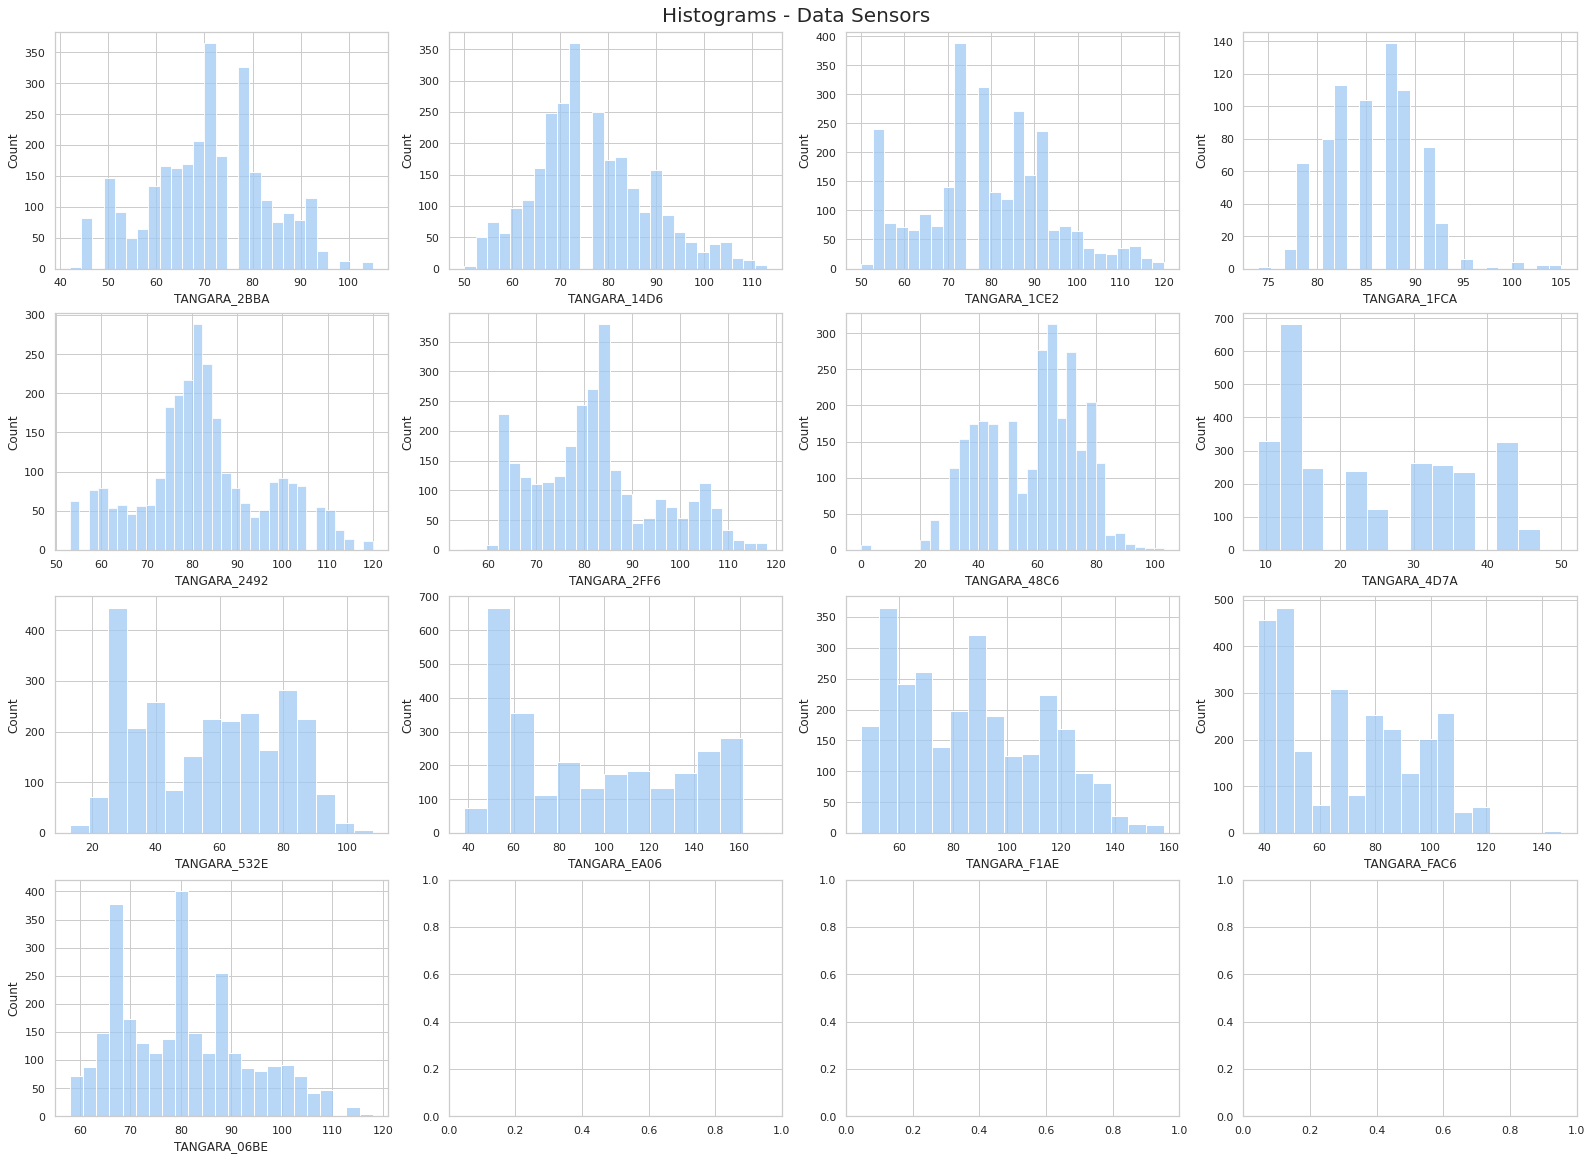

In [12]:
# Plot Histograms
histplots(aqi_instant)

In [13]:
# Plot Boxplots
def boxplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Boxplots - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.boxplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]], orient="h", x=data_sensors[data_sensors.columns[k]])
            k += 1

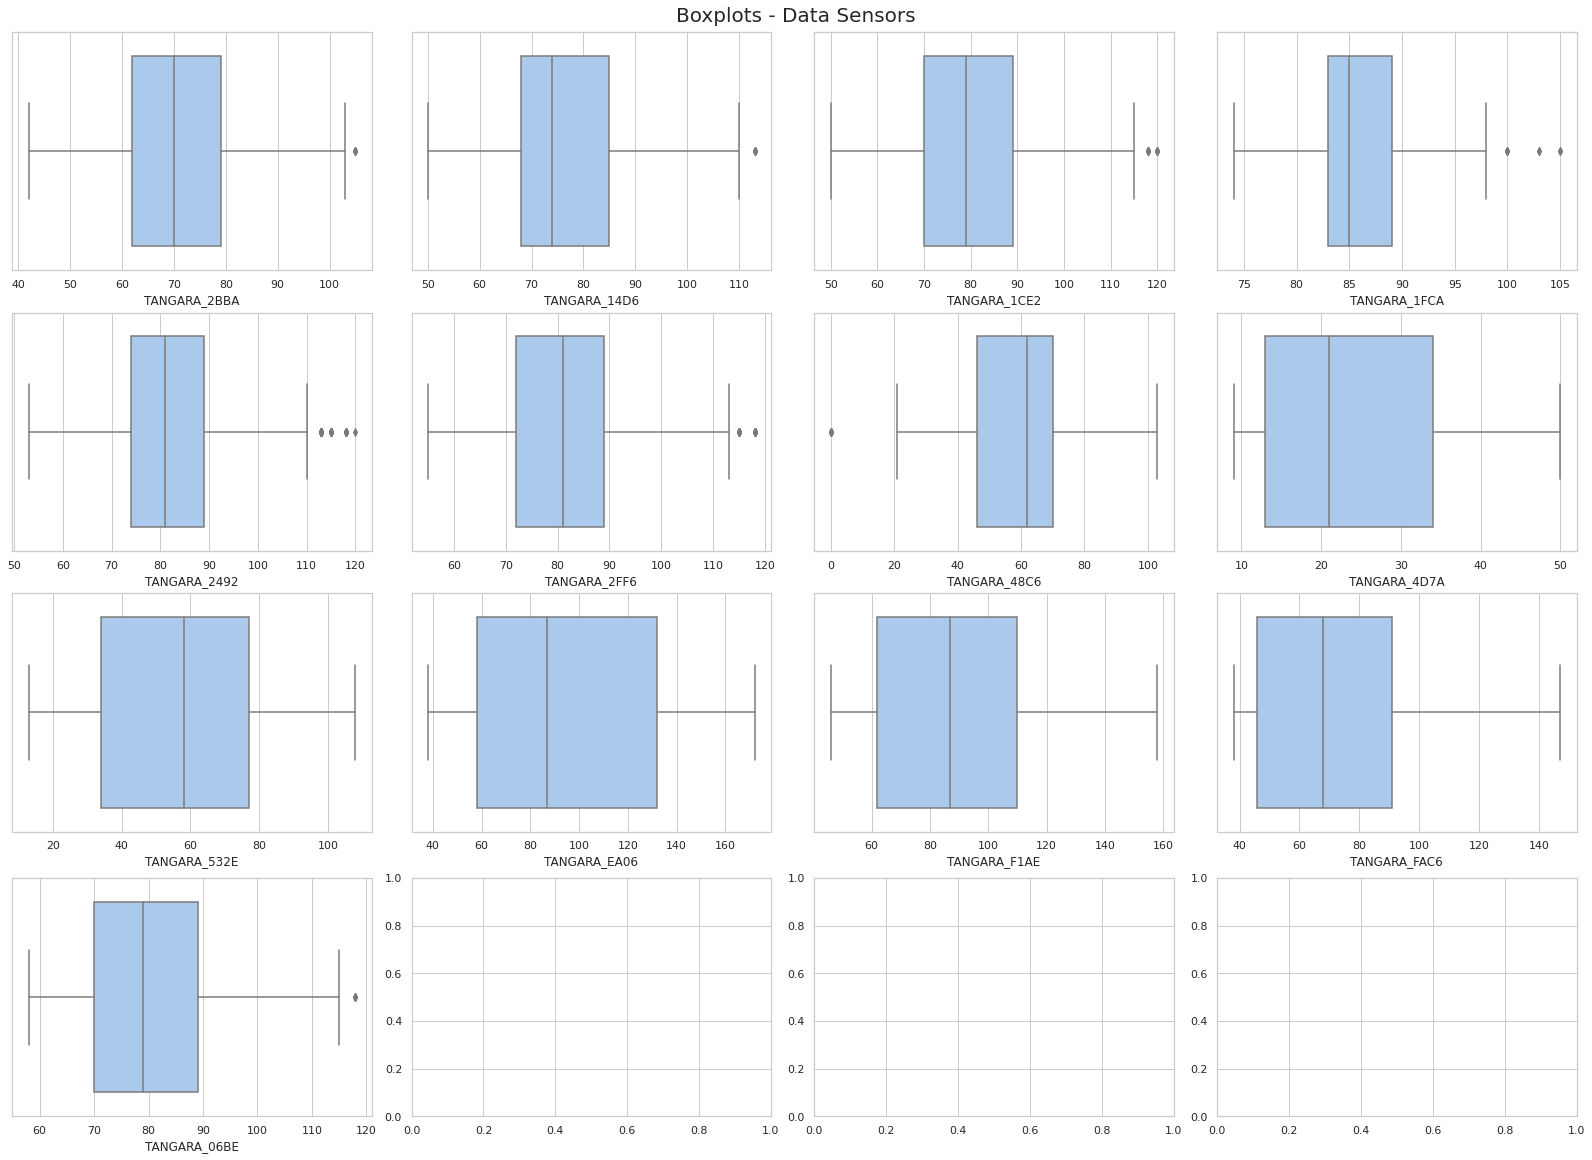

In [14]:
# Plot Boxplots
boxplots(aqi_instant)

In [15]:
# Plot Lineplots
def lineplots(data_sensors):
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)

    fig.suptitle('Timeline - Data Sensors', fontsize=20)

    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.lineplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

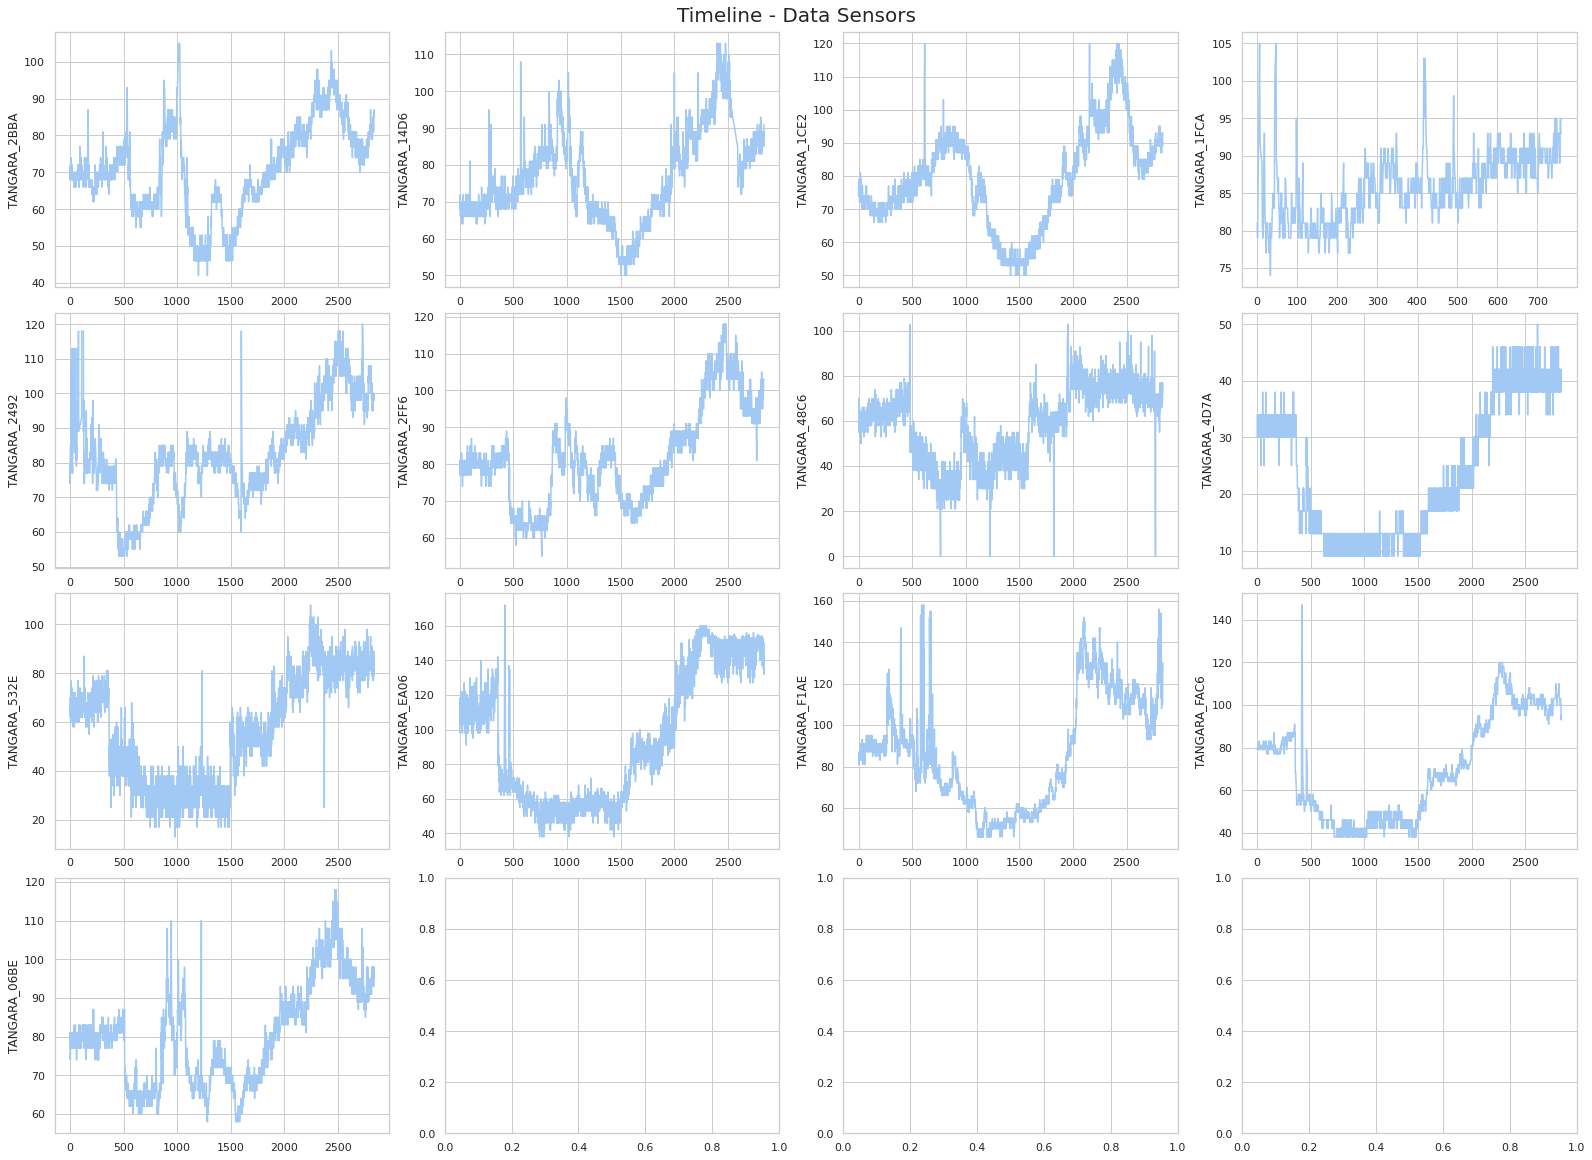

In [16]:
# Plot Lineplots
lineplots(aqi_instant)

In [17]:
# Save aqi_instant into Catalog
catalog.save('aqi_instant', aqi_instant)

2022-09-10 15:25:43,506 - kedro.io.data_catalog - INFO - Saving data to `aqi_instant` (CSVDataSet)...


---

## Extraction - AQI Last Hour

In [18]:
# Kedro Catalog
pm25_last_hour = catalog.load('pm25_last_hour')
# Data Frame Sensors
pm25_last_hour.head()

2022-09-10 15:25:43,945 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_hour` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,20.625000,20.403361,22.369748,26.972973,30.030303,25.555556,16.848739,7.416667,19.350877,39.441667,29.707965,25.777778,25.285714
1,2022-09-05 15:34:30-05:00,20.175000,20.075630,20.764706,25.844828,26.931373,25.550847,17.672269,7.720339,19.452174,39.770642,30.155172,25.378151,25.474576
2,2022-09-05 16:34:30-05:00,20.883333,22.008333,21.826087,28.647059,24.864407,25.364407,18.075000,7.482456,21.422414,42.401786,34.887931,27.459459,25.403361
3,2022-09-05 17:34:30-05:00,21.862069,21.605263,23.203540,28.521739,20.973451,25.965217,20.112069,4.639640,11.300000,25.596154,32.184211,17.009434,26.096491
4,2022-09-05 18:34:30-05:00,22.025210,22.820513,24.872881,28.907563,14.803419,18.470588,12.239316,3.491379,10.336283,18.655172,29.198198,12.963303,21.186441


In [19]:
# Check Data Types
pm25_last_hour.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

In [20]:
# Data Frame AQI Last Hour
aqi_last_hour = pm25_to_aqi(pm25_last_hour)
aqi_last_hour.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,69,69,73,83.0,89,80,61,31,67,111,89,80,79
1,2022-09-05 15:34:30-05:00,69,68,70,80.0,83,80,63,33,67,112,90,79,80
2,2022-09-05 16:34:30-05:00,70,72,72,86.0,78,79,64,32,71,118,99,84,79
3,2022-09-05 17:34:30-05:00,72,71,75,86.0,70,81,68,20,48,80,94,62,81
4,2022-09-05 18:34:30-05:00,72,74,78,87.0,57,65,52,15,43,65,87,53,71


In [21]:
# Describe Data
pm25_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,5.380139,5.648283,6.808559,1.746974,6.082966,5.856329,5.811612,2.842651,8.238649,16.973664,11.381201,10.409445,5.680177
min,11.553398,14.211864,13.525000,25.844828,14.803419,17.767241,7.359649,2.364407,6.721739,12.966667,12.274510,9.666667,17.550847
25%,16.777083,20.321429,21.560742,27.747356,22.531780,23.104627,10.987500,2.857110,8.268553,14.903484,17.463007,10.891277,21.148164
50%,21.372701,23.868506,25.281573,28.647059,26.317797,25.795109,16.845203,4.788846,14.142788,28.766810,29.453081,19.430172,25.438969
75%,24.925000,27.645209,29.999620,29.562477,29.885781,29.120089,20.939890,7.875724,24.363551,47.478992,38.426029,30.458387,29.193147
max,31.416667,36.269565,39.508475,30.914894,38.922414,38.241667,25.282051,9.773913,30.801802,62.641509,46.000000,40.179245,36.805085


In [22]:
# Describe Data
aqi_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,70.875000,76.958333,79.166667,86.142857,82.208333,82.041667,58.416667,23.916667,56.541667,95.666667,86.541667,70.000000,80.166667
std,11.429605,11.932707,14.511365,3.804759,13.081614,12.712470,15.027270,11.894159,21.542636,37.879290,25.341115,23.557515,12.092638
min,49.000000,56.000000,54.000000,80.000000,57.000000,63.000000,31.000000,10.000000,28.000000,53.000000,52.000000,41.000000,63.000000
25%,61.750000,68.750000,71.500000,84.500000,73.500000,74.250000,46.500000,12.750000,35.250000,57.750000,62.500000,46.000000,70.750000
50%,71.000000,76.000000,79.000000,86.000000,81.500000,80.500000,61.000000,20.500000,56.000000,87.000000,88.000000,67.000000,79.500000
75%,78.250000,83.750000,89.250000,88.500000,89.000000,87.250000,70.500000,33.500000,77.000000,131.250000,108.500000,90.000000,87.500000
max,92.000000,103.000000,111.000000,91.000000,110.000000,108.000000,79.000000,41.000000,91.000000,155.000000,127.000000,113.000000,105.000000


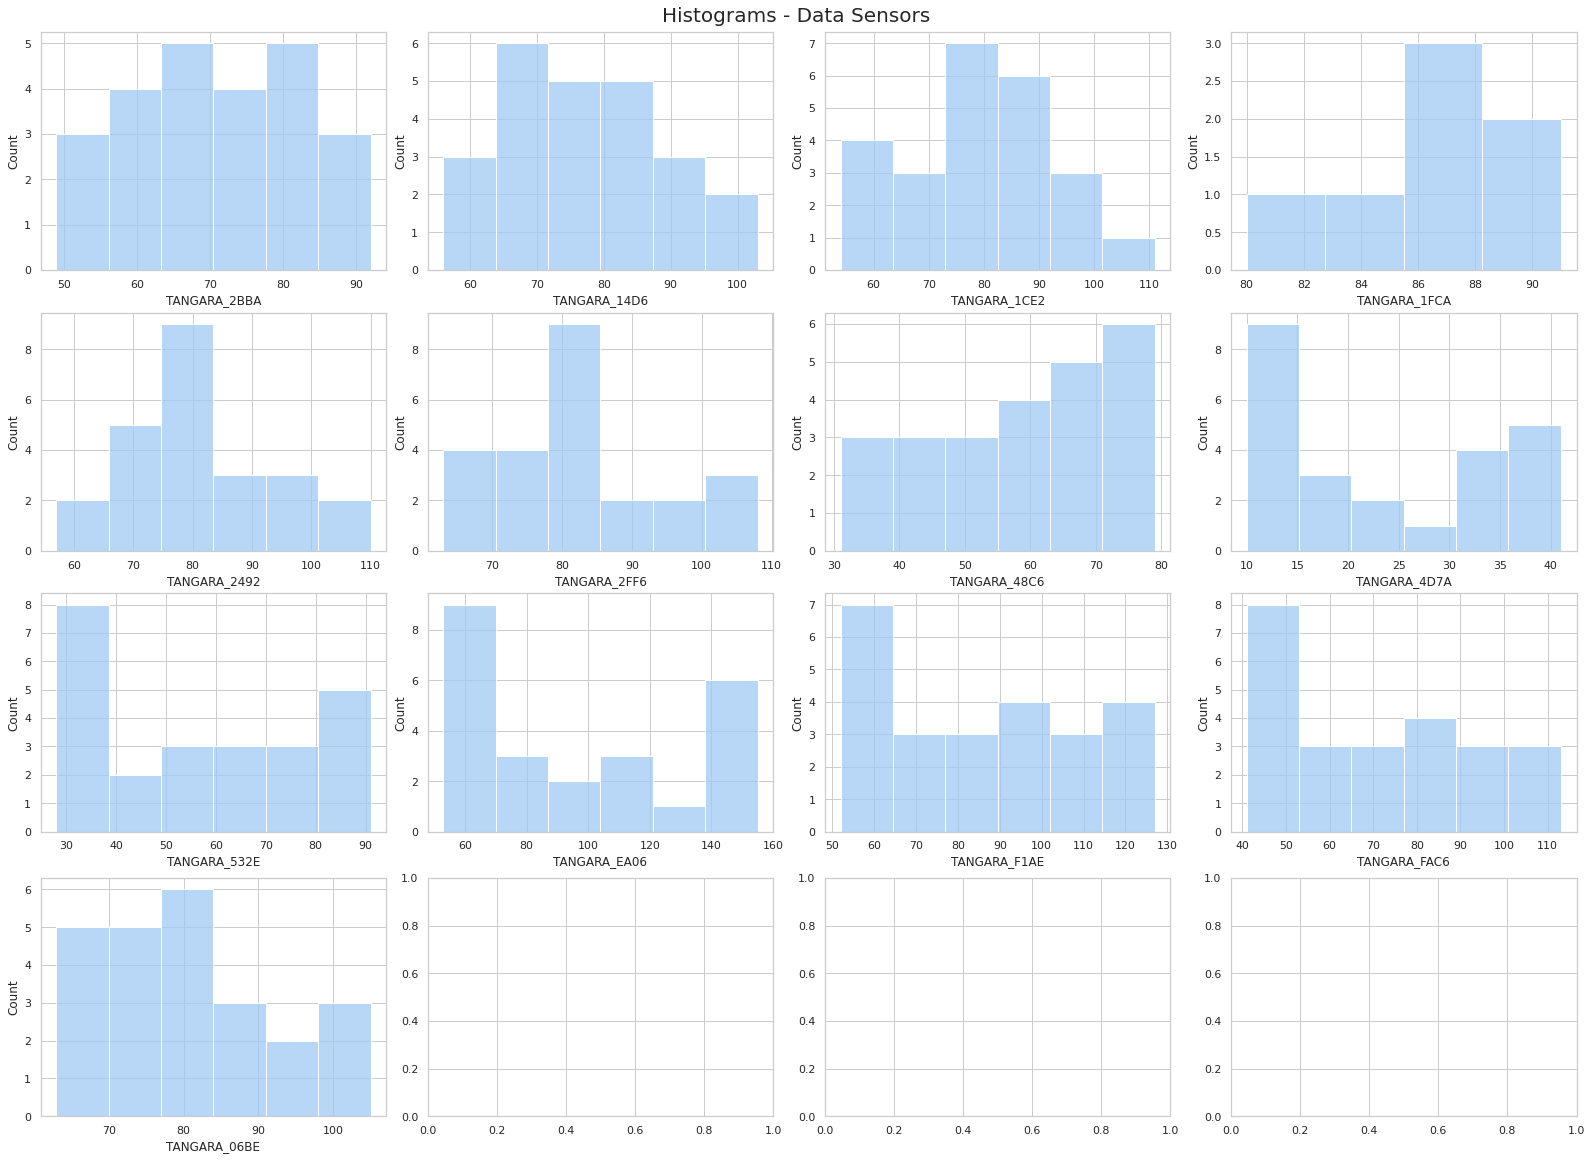

In [23]:
# Plot Histograms
histplots(aqi_last_hour)

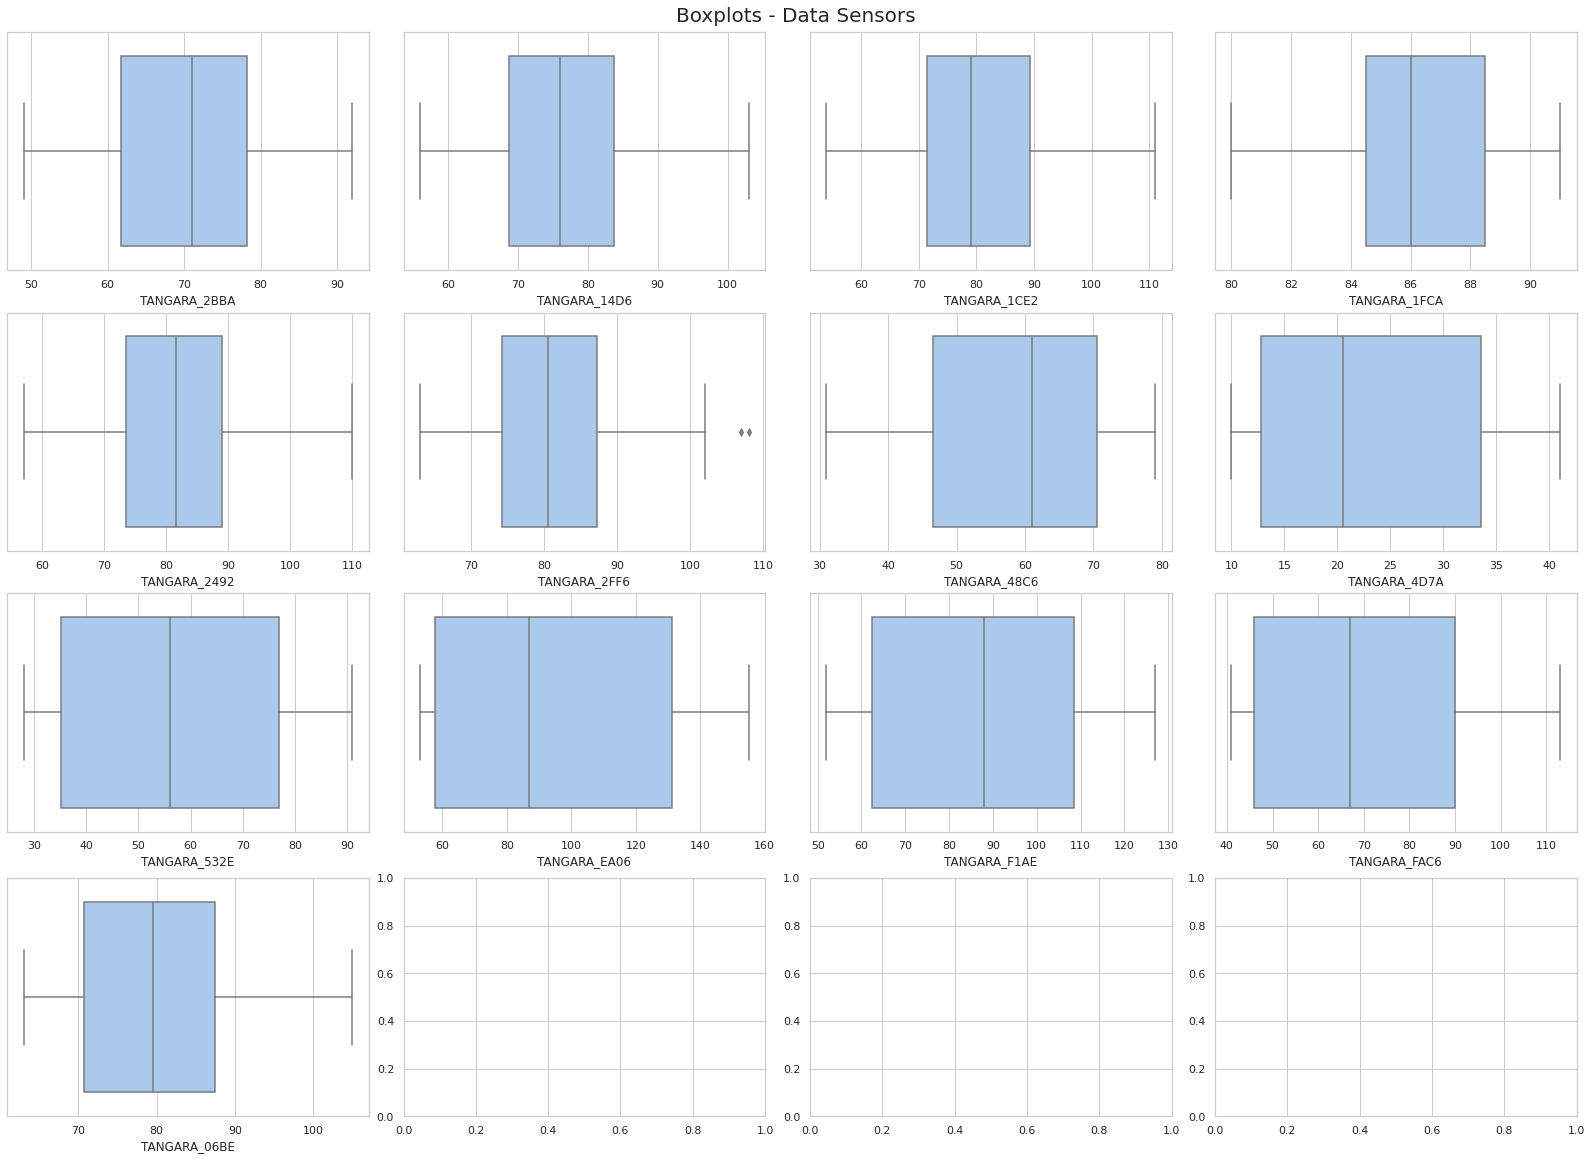

In [24]:
# Plot Boxplots
boxplots(aqi_last_hour)

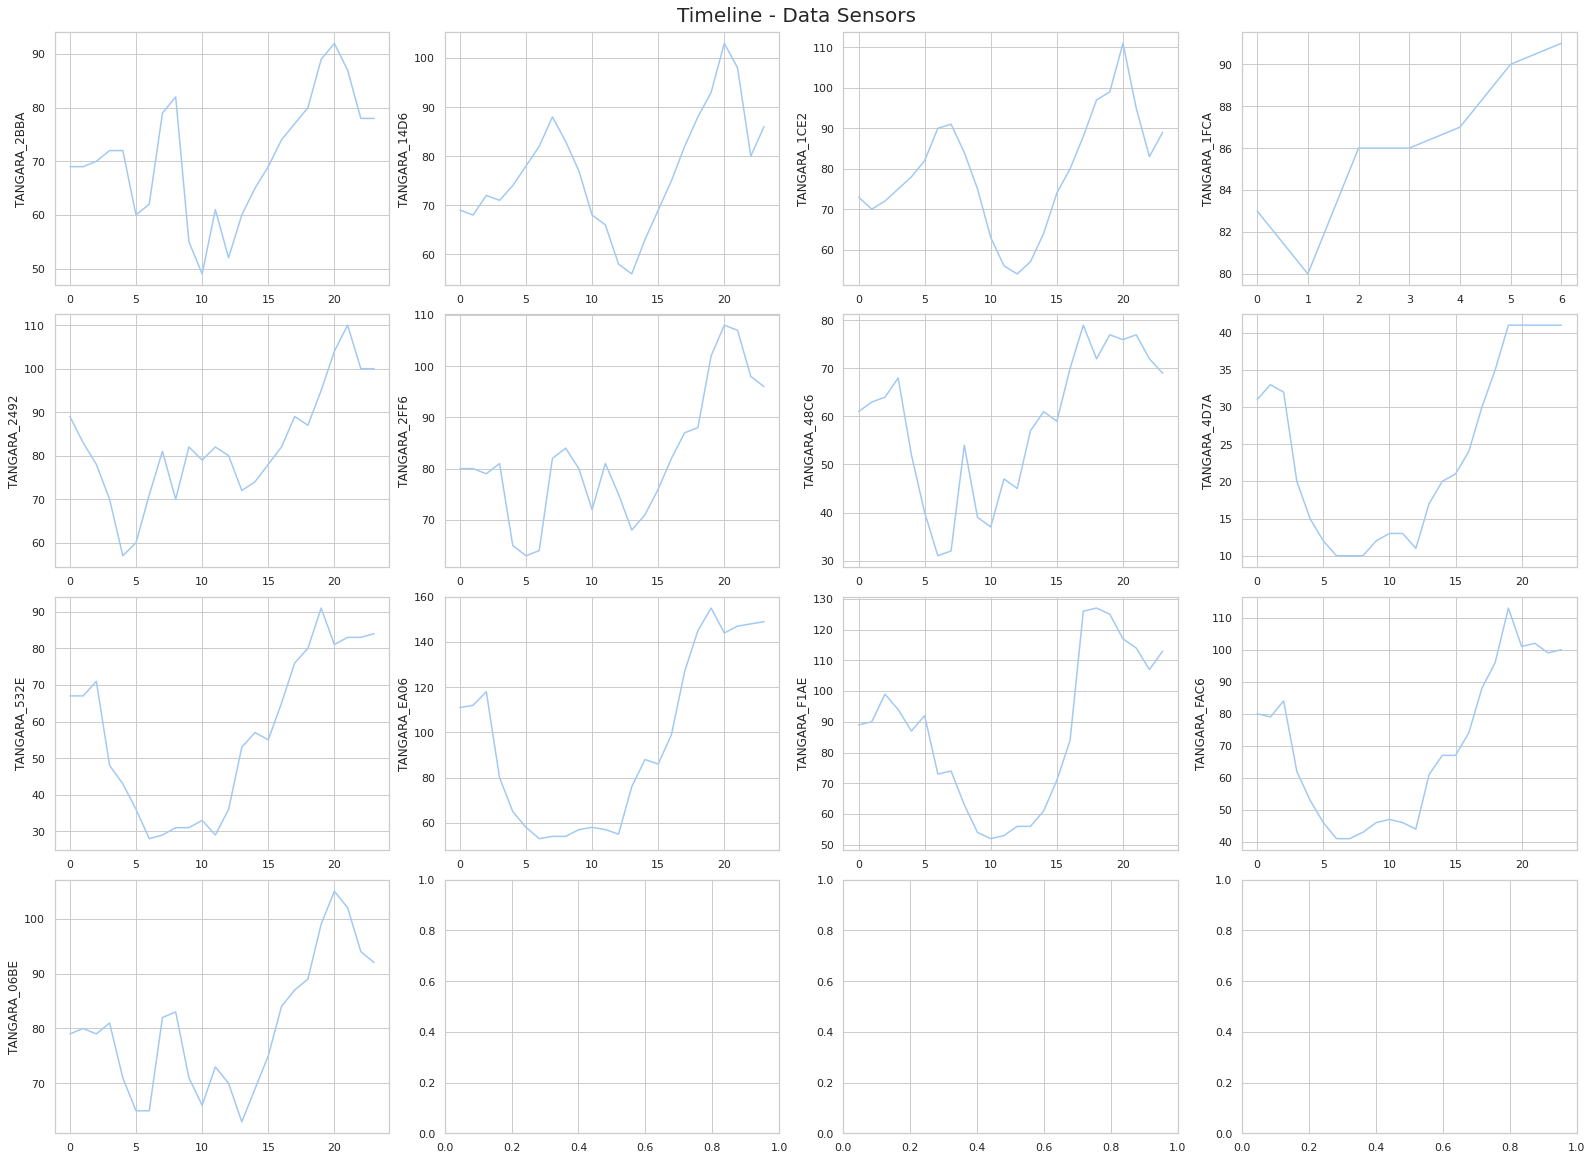

In [25]:
# Plot Lineplots
lineplots(aqi_last_hour)

In [26]:
# Save aqi_last_hour into Catalog
catalog.save('aqi_last_hour', aqi_last_hour)

2022-09-10 15:26:09,352 - kedro.io.data_catalog - INFO - Saving data to `aqi_last_hour` (CSVDataSet)...


---

## Extraction - AQI Last 8 Hours

In [27]:
# Kedro Catalog
pm25_last_8h = catalog.load('pm25_last_8h')
# Data Frame Sensors
pm25_last_8h.head()

2022-09-10 15:26:09,860 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_8h` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 21:34:30-05:00,20.450529,23.451424,25.085717,28.575207,22.697279,22.909232,13.676092,4.791453,13.017816,25.894800,29.063319,17.369896,23.365145
1,2022-09-06 05:34:30-05:00,16.983224,19.714861,18.941228,NaN,24.291987,23.714422,12.531423,3.381996,9.891306,19.070315,15.427135,13.594368,21.467174
2,2022-09-06 13:34:30-05:00,26.500840,29.497655,31.632161,NaN,33.025487,33.009407,22.769886,8.714268,25.822648,51.503171,40.498112,33.380570,32.133223


In [28]:
# Check Data Types
pm25_last_8h.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

In [29]:
# Data Frame AQI Last 8 Hours
aqi_last_8h = pm25_to_aqi(pm25_last_8h)
aqi_last_8h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 21:34:30-05:00,69,75,79,86.0,74,74,55,20,53,81,87,63,75
1,2022-09-06 05:34:30-05:00,62,67,66,NaN,77,76,52,15,42,66,58,55,71
2,2022-09-06 13:34:30-05:00,82,88,93,NaN,95,95,74,37,80,141,114,96,94


In [30]:
# Describe Data
pm25_last_8h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,4.816871,4.936629,6.346527,NaN,5.560111,5.613356,5.610013,2.763095,8.441430,17.098988,12.551586,10.504682,5.689846
min,16.983224,19.714861,18.941228,28.575207,22.697279,22.909232,12.531423,3.381996,9.891306,19.070315,15.427135,13.594368,21.467174
25%,18.716876,21.583143,22.013473,28.575207,23.494633,23.311827,13.103757,4.086725,11.454561,22.482558,22.245227,15.482132,22.416160
50%,20.450529,23.451424,25.085717,28.575207,24.291987,23.714422,13.676092,4.791453,13.017816,25.894800,29.063319,17.369896,23.365145
75%,23.475684,26.474539,28.358939,28.575207,28.658737,28.361914,18.222989,6.752861,19.420232,38.698985,34.780715,25.375233,27.749184
max,26.500840,29.497655,31.632161,28.575207,33.025487,33.009407,22.769886,8.714268,25.822648,51.503171,40.498112,33.380570,32.133223


In [31]:
# Describe Data
aqi_last_8h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,3.000000,3.000000,3.000000,1.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000
mean,71.000000,76.666667,79.333333,86.0,82.000000,81.666667,60.333333,24.000000,58.333333,96.00000,86.333333,71.333333,80.000000
std,10.148892,10.598742,13.503086,NaN,11.357817,11.590226,11.930353,11.532563,19.553346,39.68627,28.005952,21.733231,12.288206
min,62.000000,67.000000,66.000000,86.0,74.000000,74.000000,52.000000,15.000000,42.000000,66.00000,58.000000,55.000000,71.000000
25%,65.500000,71.000000,72.500000,86.0,75.500000,75.000000,53.500000,17.500000,47.500000,73.50000,72.500000,59.000000,73.000000
50%,69.000000,75.000000,79.000000,86.0,77.000000,76.000000,55.000000,20.000000,53.000000,81.00000,87.000000,63.000000,75.000000
75%,75.500000,81.500000,86.000000,86.0,86.000000,85.500000,64.500000,28.500000,66.500000,111.00000,100.500000,79.500000,84.500000
max,82.000000,88.000000,93.000000,86.0,95.000000,95.000000,74.000000,37.000000,80.000000,141.00000,114.000000,96.000000,94.000000


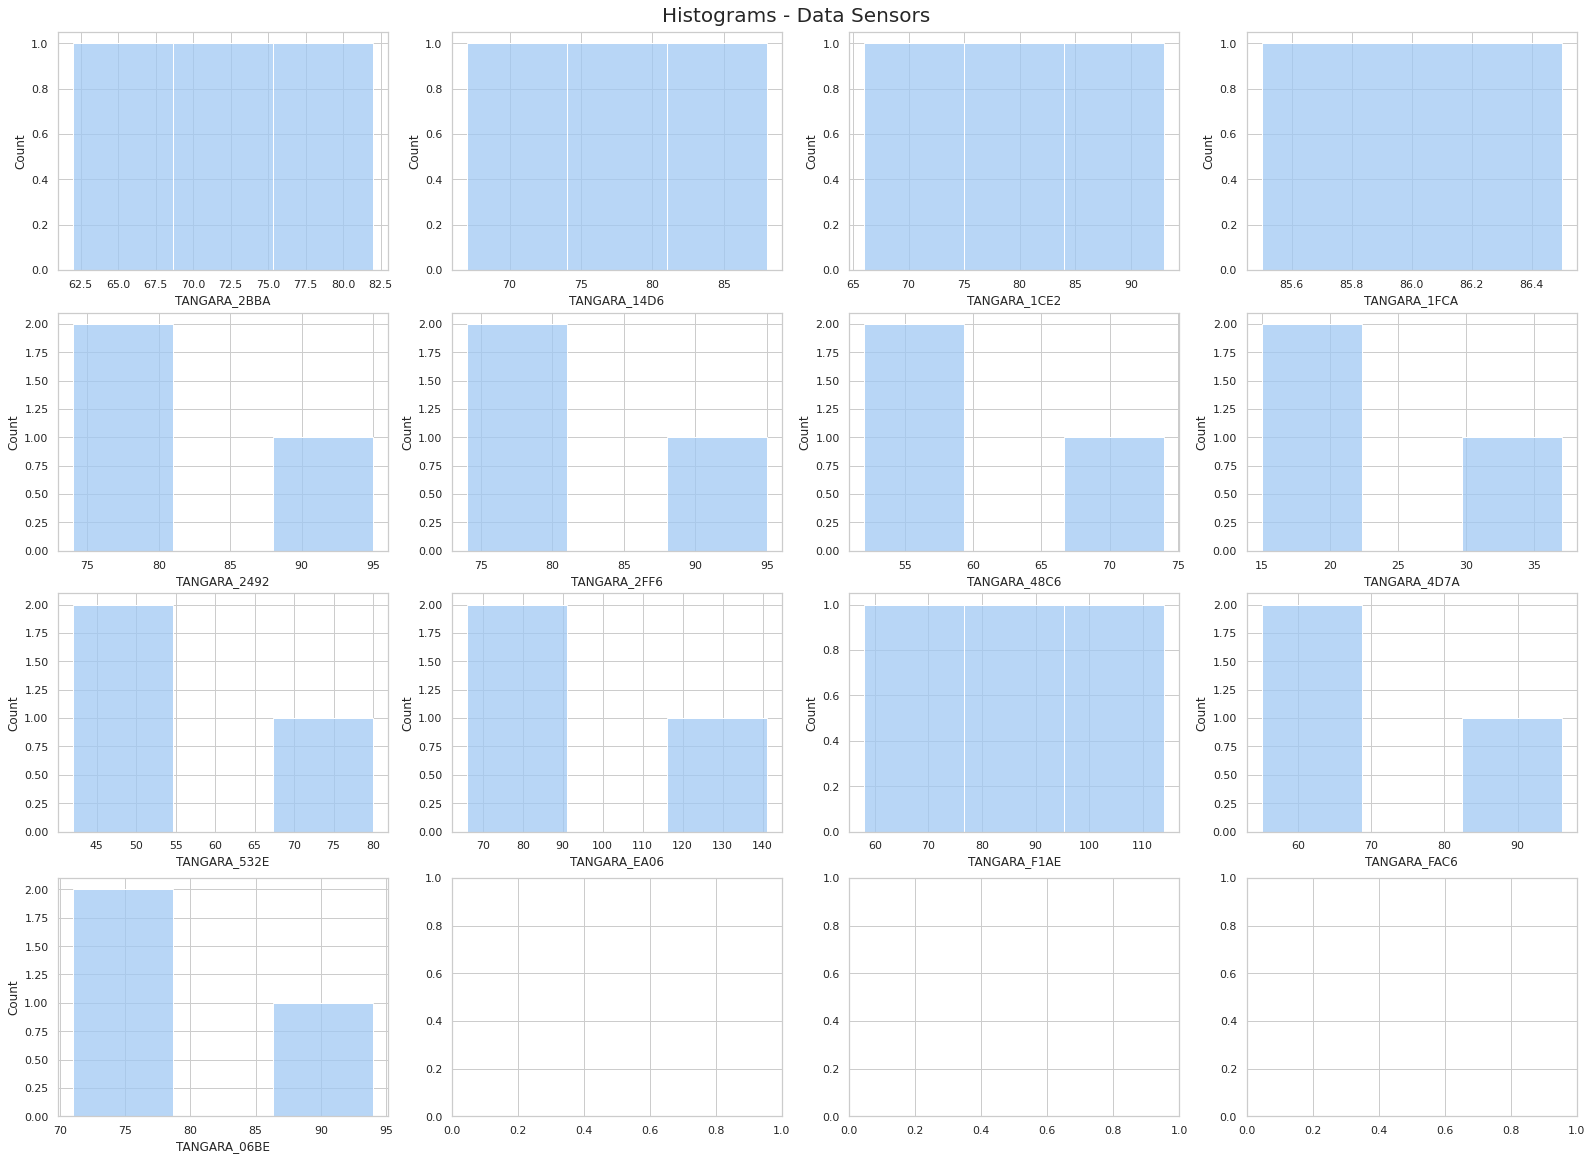

In [32]:
# Plot Histograms
histplots(aqi_last_8h)

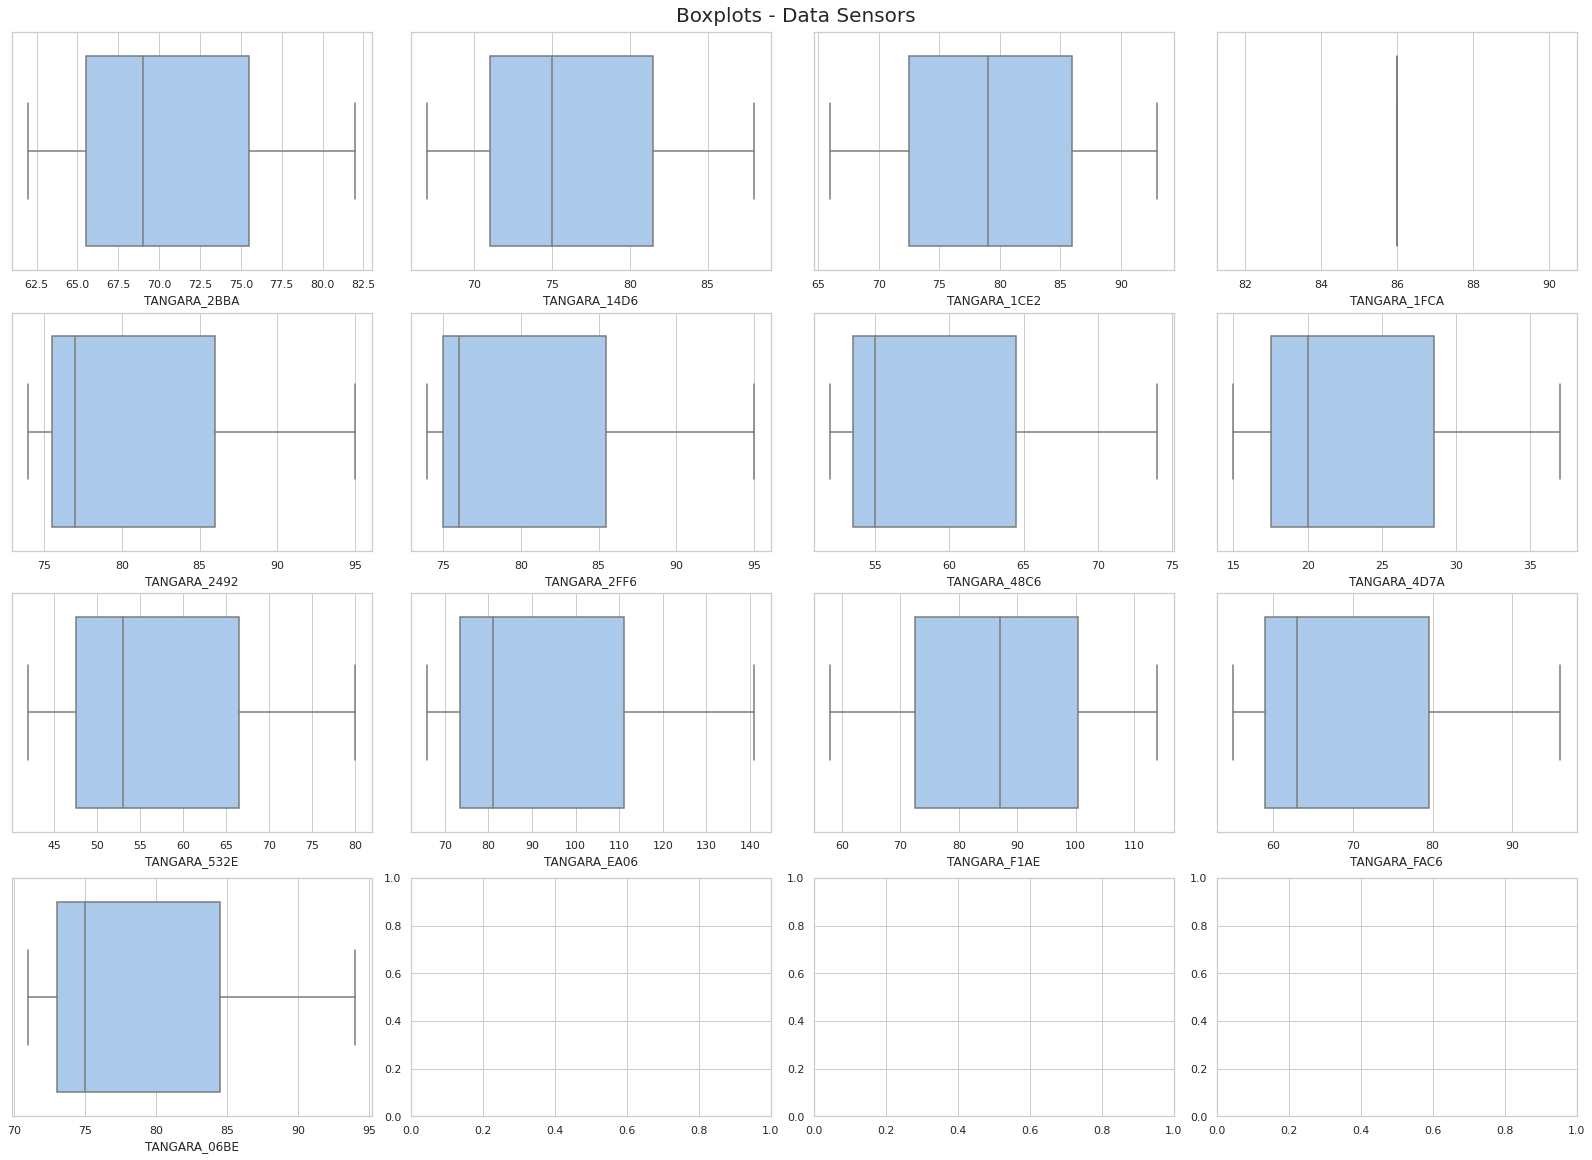

In [33]:
# Plot Boxplots
boxplots(aqi_last_8h)

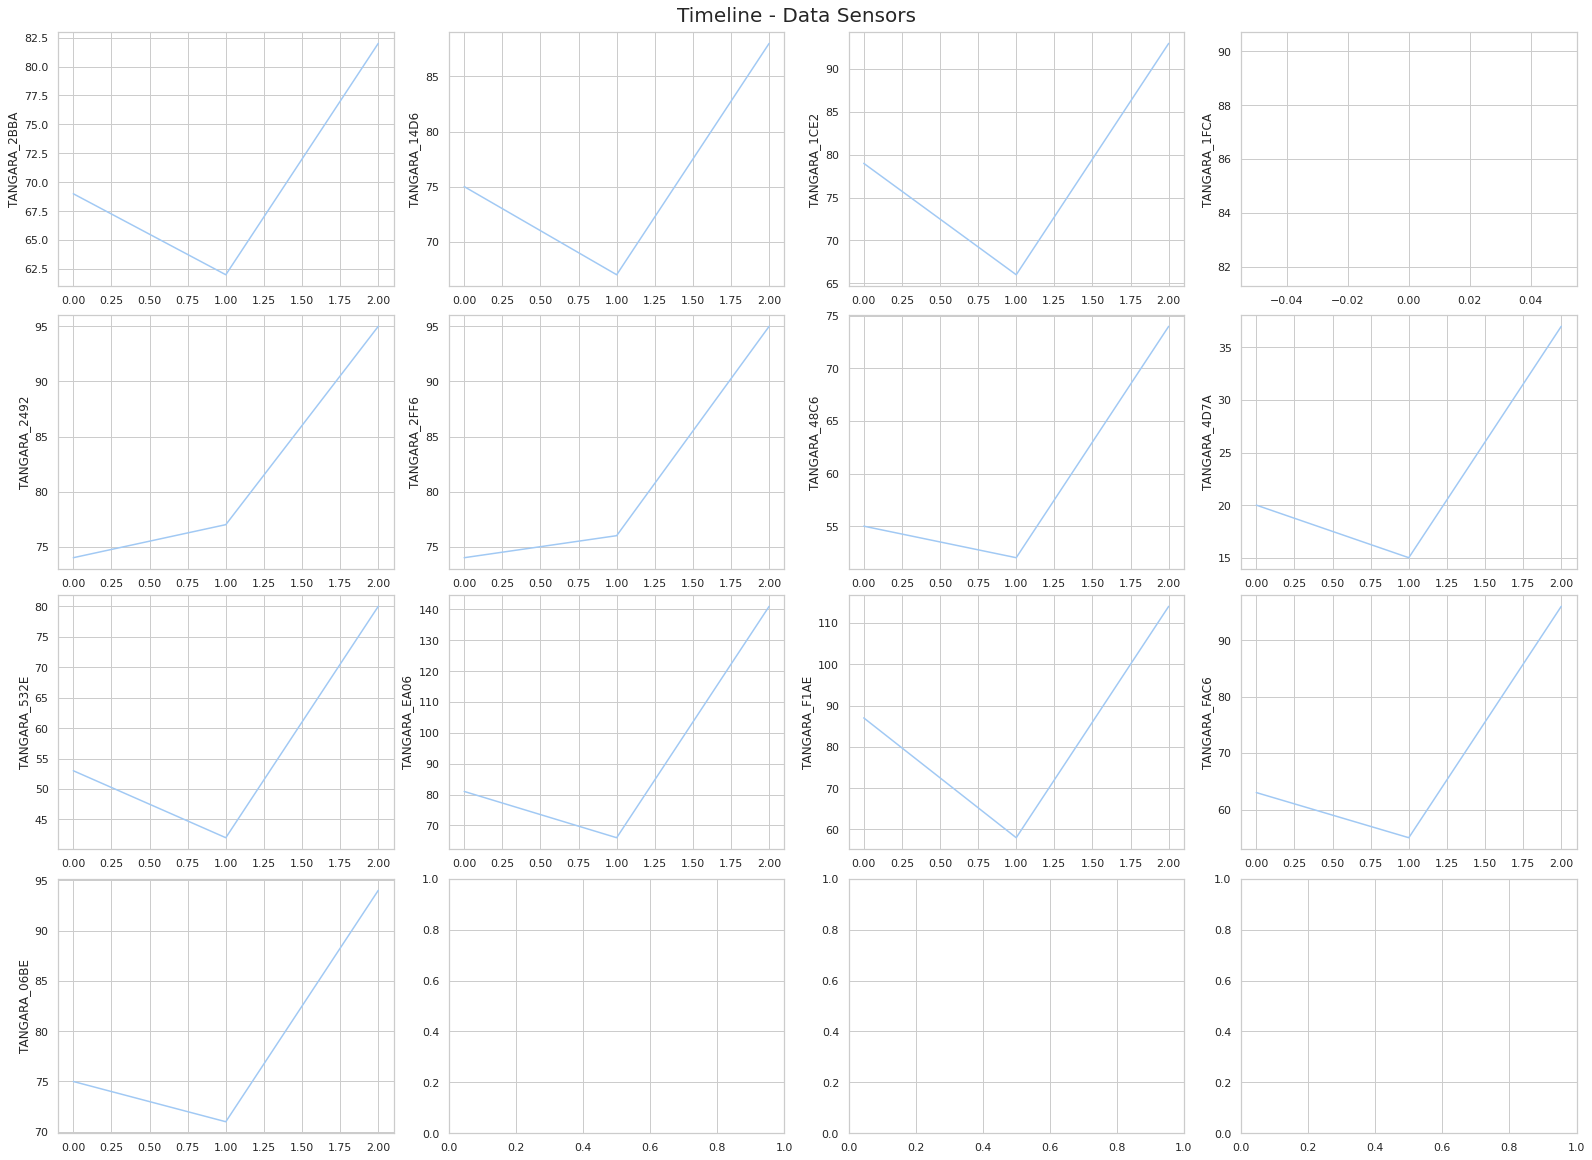

In [34]:
# Plot Lineplots
lineplots(aqi_last_8h)

In [35]:
# Save aqi_last_8h into Catalog
catalog.save('aqi_last_8h', aqi_last_8h)

2022-09-10 15:26:35,489 - kedro.io.data_catalog - INFO - Saving data to `aqi_last_8h` (CSVDataSet)...


---

## Extraction - AQI Last 12 Hours

In [36]:
# Kedro Catalog
pm25_last_12h = catalog.load('pm25_last_12h')
# Data Frame Sensors
pm25_last_12h.head()

2022-09-10 15:26:35,943 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_12h` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 01:34:30-05:00,19.347478,23.165593,23.595339,28.575207,23.402513,23.734368,12.624426,4.112644,11.130586,22.051994,24.085174,15.159342,23.052585
1,2022-09-06 13:34:30-05:00,23.275584,25.277034,26.844065,NaN,29.940656,29.354339,20.027175,7.145834,21.357261,42.260197,32.573870,27.737214,28.257776


In [37]:
# Check Data Types
pm25_last_12h.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

In [38]:
# Data Frame AQI Last 12 Hours
aqi_last_12h = pm25_to_aqi(pm25_last_12h)
aqi_last_12h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 01:34:30-05:00,67,75,76,86.0,75,76,53,18,47,73,77,58,75
1,2022-09-06 13:34:30-05:00,75,79,82,NaN,89,88,68,30,71,118,95,84,86


In [39]:
# Describe Data
pm25_last_12h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,2.777591,1.493014,2.297196,NaN,4.623165,3.973919,5.234534,2.144789,7.231352,14.289357,6.002414,8.893899,3.680626
min,19.347478,23.165593,23.595339,28.575207,23.402513,23.734368,12.624426,4.112644,11.130586,22.051994,24.085174,15.159342,23.052585
25%,20.329504,23.693453,24.407521,28.575207,25.037049,25.139361,14.475113,4.870942,13.687254,27.104044,26.207348,18.303810,24.353883
50%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
75%,22.293557,24.749174,26.031884,28.575207,28.306120,27.949346,18.176488,6.387537,18.800592,37.208146,30.451696,24.592746,26.956478
max,23.275584,25.277034,26.844065,28.575207,29.940656,29.354339,20.027175,7.145834,21.357261,42.260197,32.573870,27.737214,28.257776


In [40]:
# Describe Data
aqi_last_12h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2.000000,2.000000,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,71.000000,77.000000,79.000000,86.0,82.000000,82.000000,60.500000,24.000000,59.000000,95.500000,86.000000,71.000000,80.500000
std,5.656854,2.828427,4.242641,NaN,9.899495,8.485281,10.606602,8.485281,16.970563,31.819805,12.727922,18.384776,7.778175
min,67.000000,75.000000,76.000000,86.0,75.000000,76.000000,53.000000,18.000000,47.000000,73.000000,77.000000,58.000000,75.000000
25%,69.000000,76.000000,77.500000,86.0,78.500000,79.000000,56.750000,21.000000,53.000000,84.250000,81.500000,64.500000,77.750000
50%,71.000000,77.000000,79.000000,86.0,82.000000,82.000000,60.500000,24.000000,59.000000,95.500000,86.000000,71.000000,80.500000
75%,73.000000,78.000000,80.500000,86.0,85.500000,85.000000,64.250000,27.000000,65.000000,106.750000,90.500000,77.500000,83.250000
max,75.000000,79.000000,82.000000,86.0,89.000000,88.000000,68.000000,30.000000,71.000000,118.000000,95.000000,84.000000,86.000000


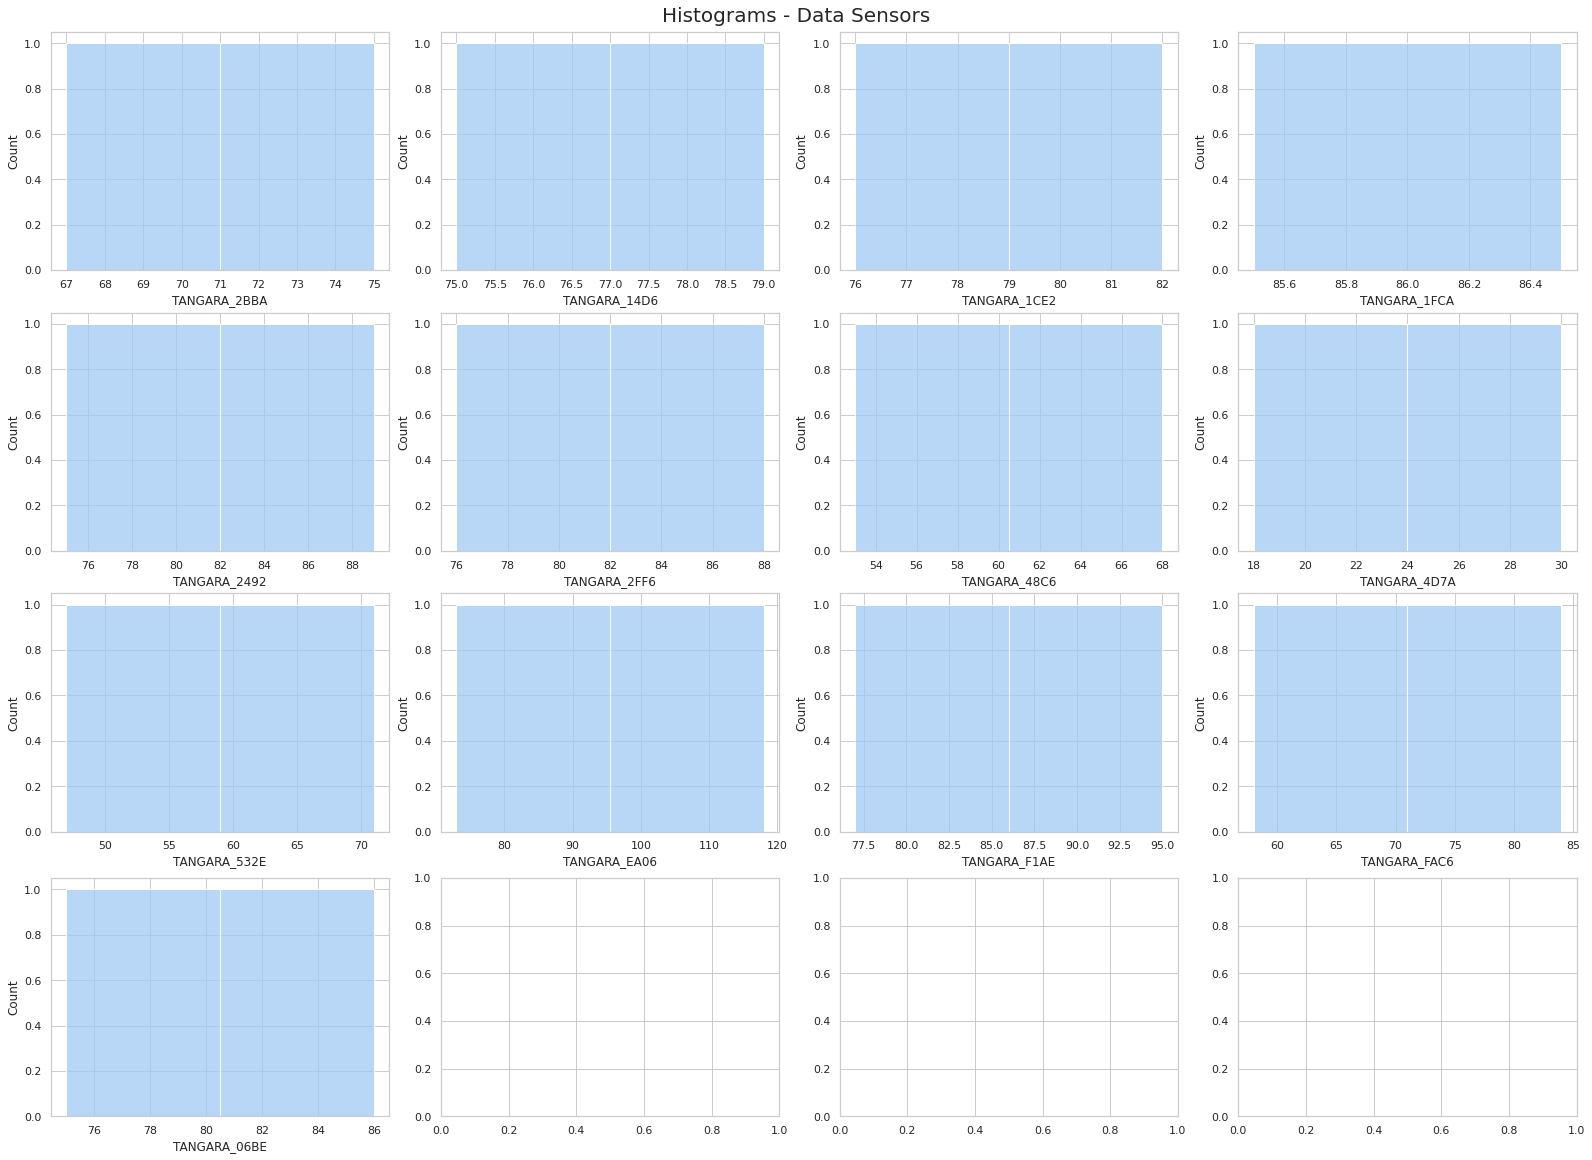

In [41]:
# Plot Histograms
histplots(aqi_last_12h)

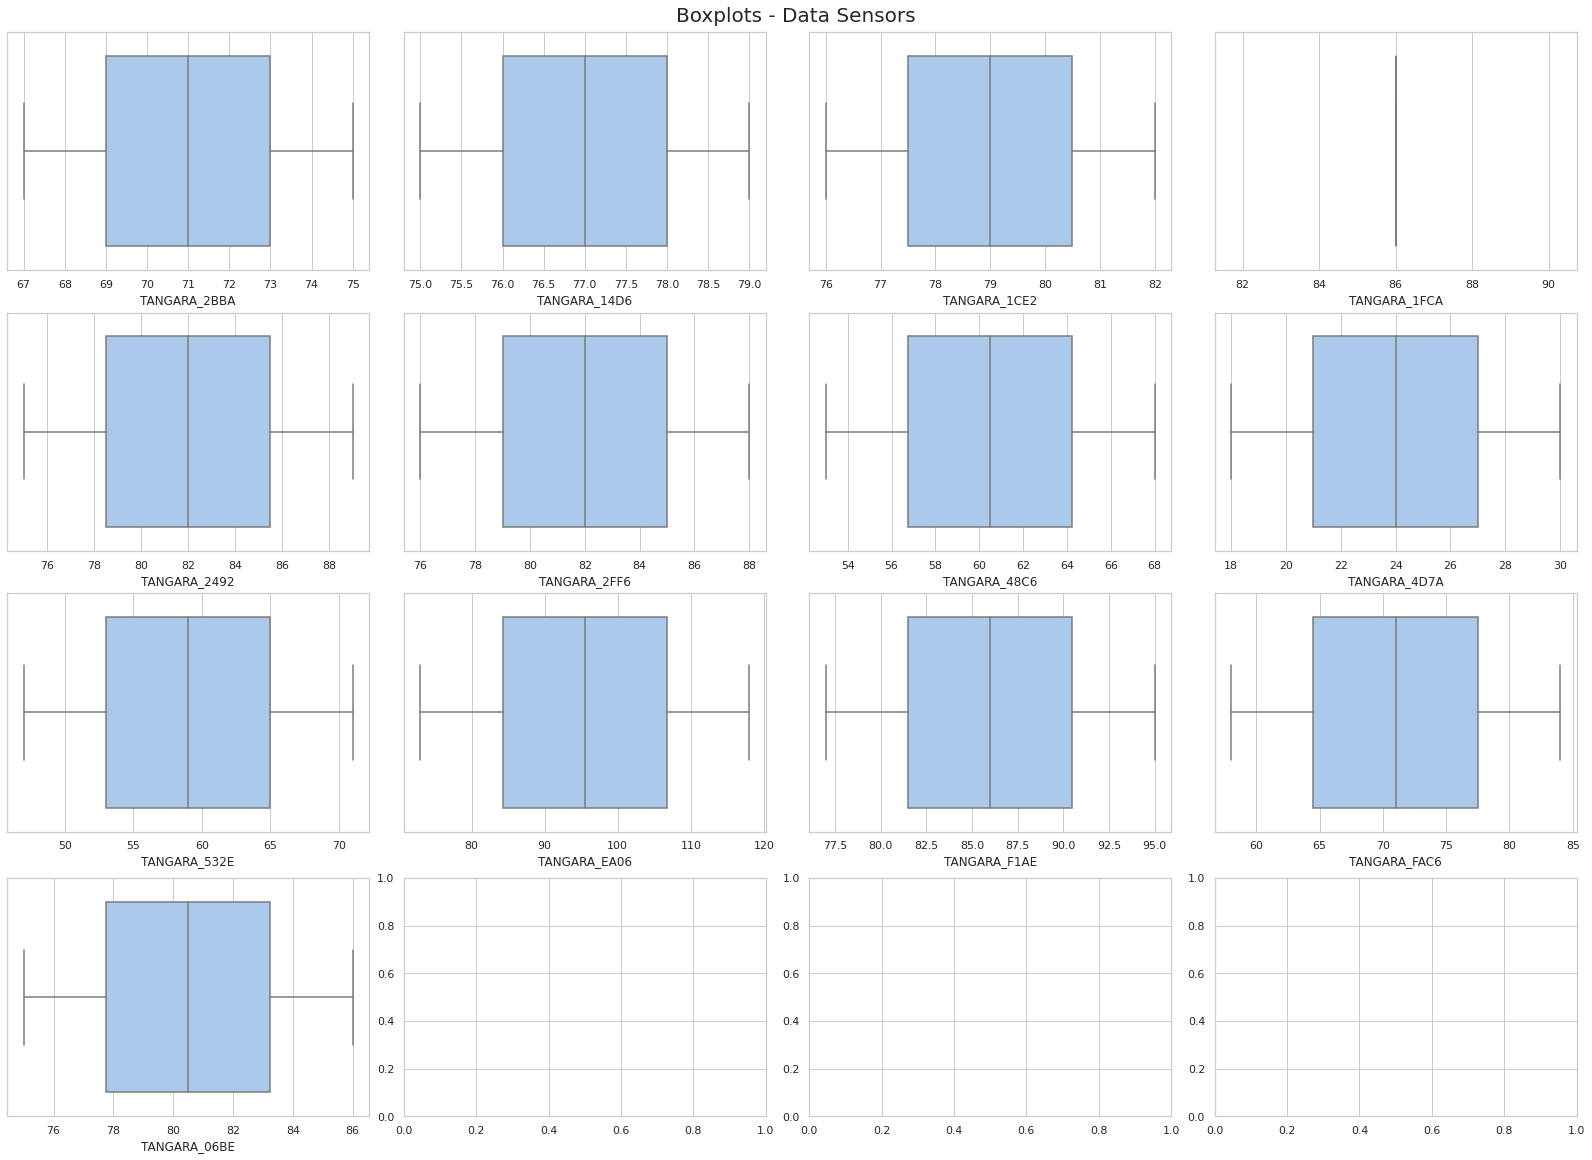

In [42]:
# Plot Boxplots
boxplots(aqi_last_12h)

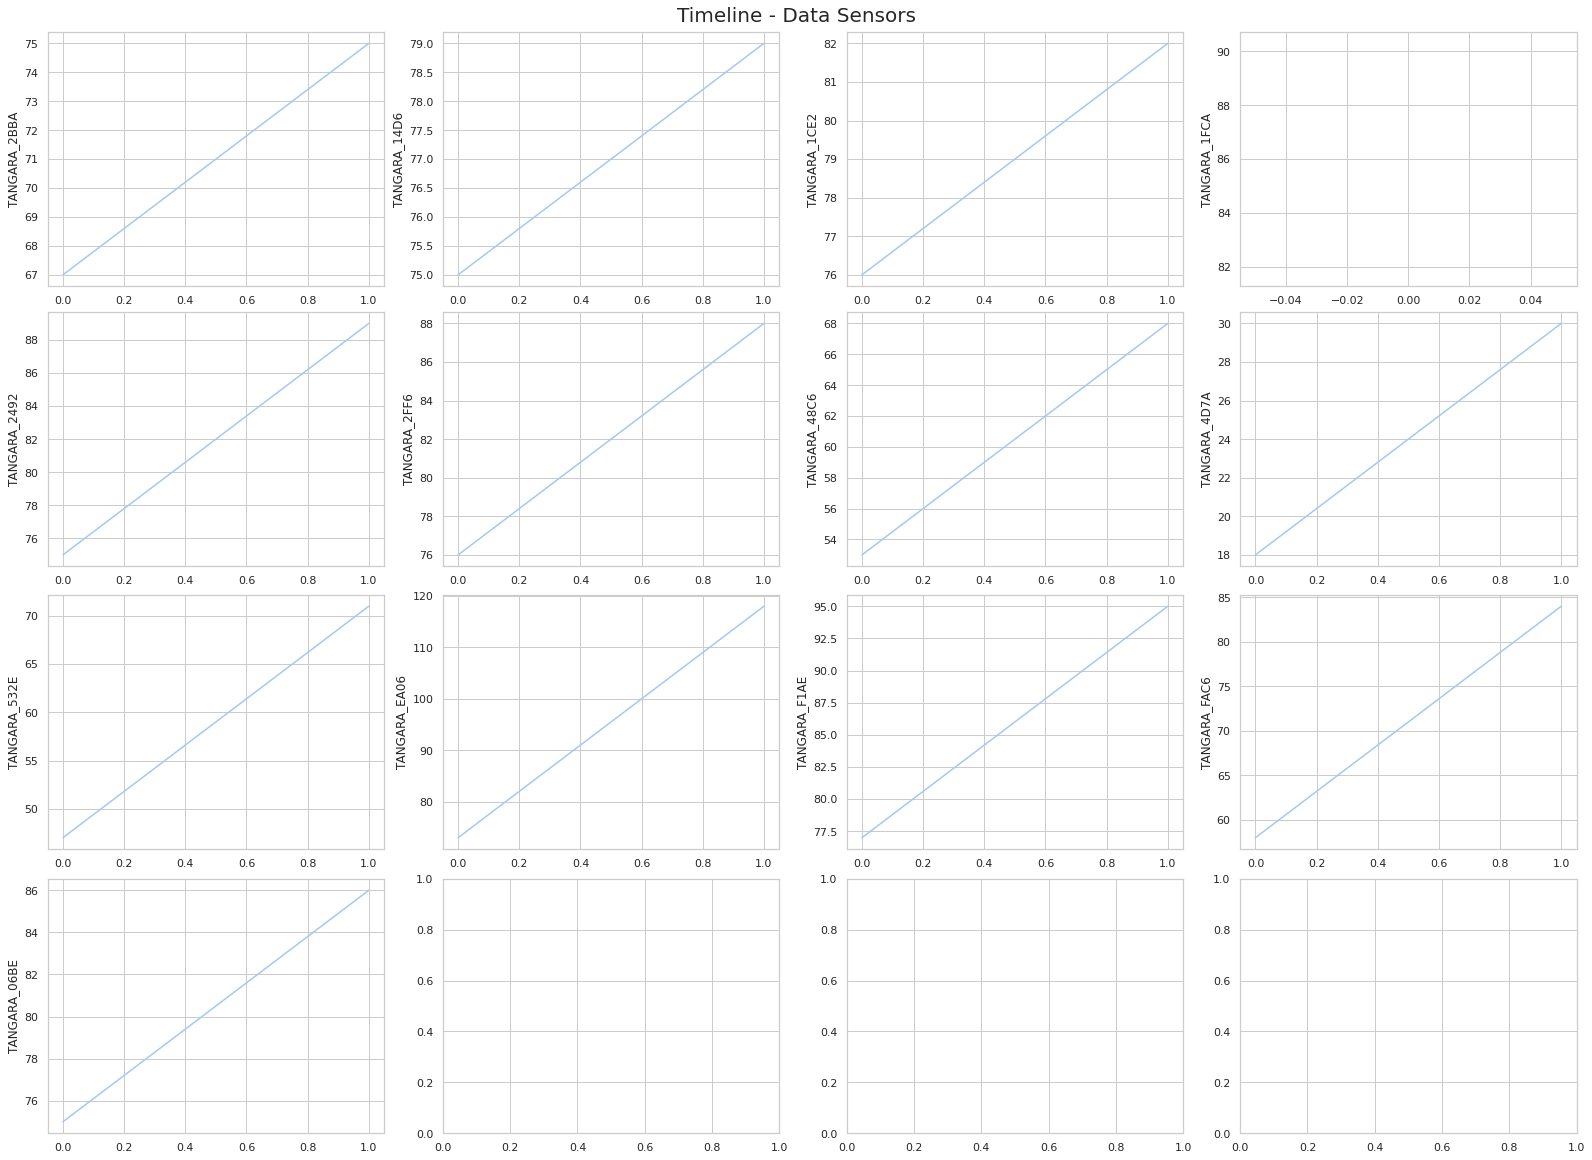

In [43]:
# Plot Lineplots
lineplots(aqi_last_12h)

In [44]:
# Save aqi_last_12h into Catalog
catalog.save('aqi_last_12h', aqi_last_12h)

2022-09-10 15:27:01,769 - kedro.io.data_catalog - INFO - Saving data to `aqi_last_12h` (CSVDataSet)...


---

## Extraction - AQI Last 24 Hours

In [45]:
# Kedro Catalog
pm25_last_24h = catalog.load('pm25_last_24h')
# Data Frame Sensors
pm25_last_24h.head()

2022-09-10 15:27:02,238 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_24h` (CSVDataSet)...


,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 13:34:30-05:00,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181


In [46]:
# Check Data Types
pm25_last_24h.dtypes

DATETIME         object
TANGARA_2BBA    float64
TANGARA_14D6    float64
TANGARA_1CE2    float64
TANGARA_1FCA    float64
TANGARA_2492    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_4D7A    float64
TANGARA_532E    float64
TANGARA_EA06    float64
TANGARA_F1AE    float64
TANGARA_FAC6    float64
TANGARA_06BE    float64
dtype: object

In [47]:
# Data Frame AQI Last 24 Hours
aqi_last_24h = pm25_to_aqi(pm25_last_24h)
aqi_last_24h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 13:34:30-05:00,71,77,79,86,82,82,60,24,60,94,86,71,80


In [48]:
# Describe Data
pm25_last_24h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
25%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
50%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
75%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
max,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181


In [49]:
# Describe Data
aqi_last_24h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0
25%,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0
50%,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0
75%,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0
max,71.0,77.0,79.0,86.0,82.0,82.0,60.0,24.0,60.0,94.0,86.0,71.0,80.0


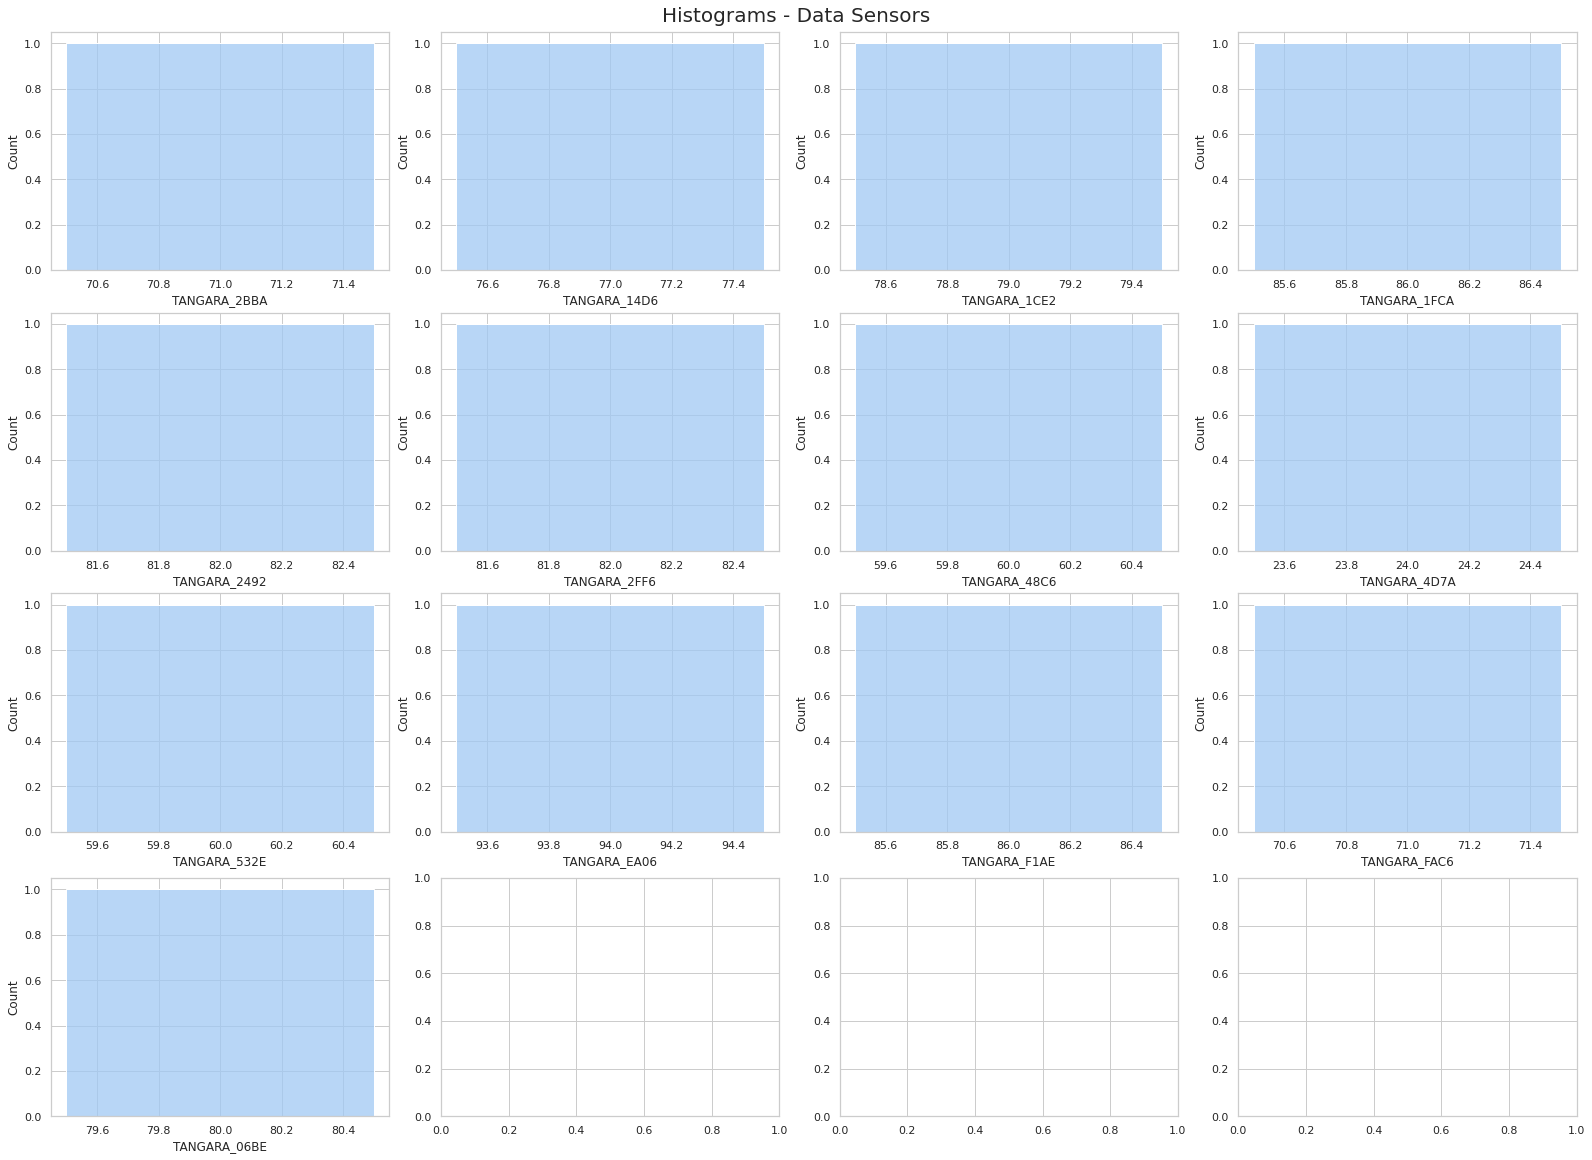

In [50]:
# Plot Histograms
histplots(aqi_last_24h)

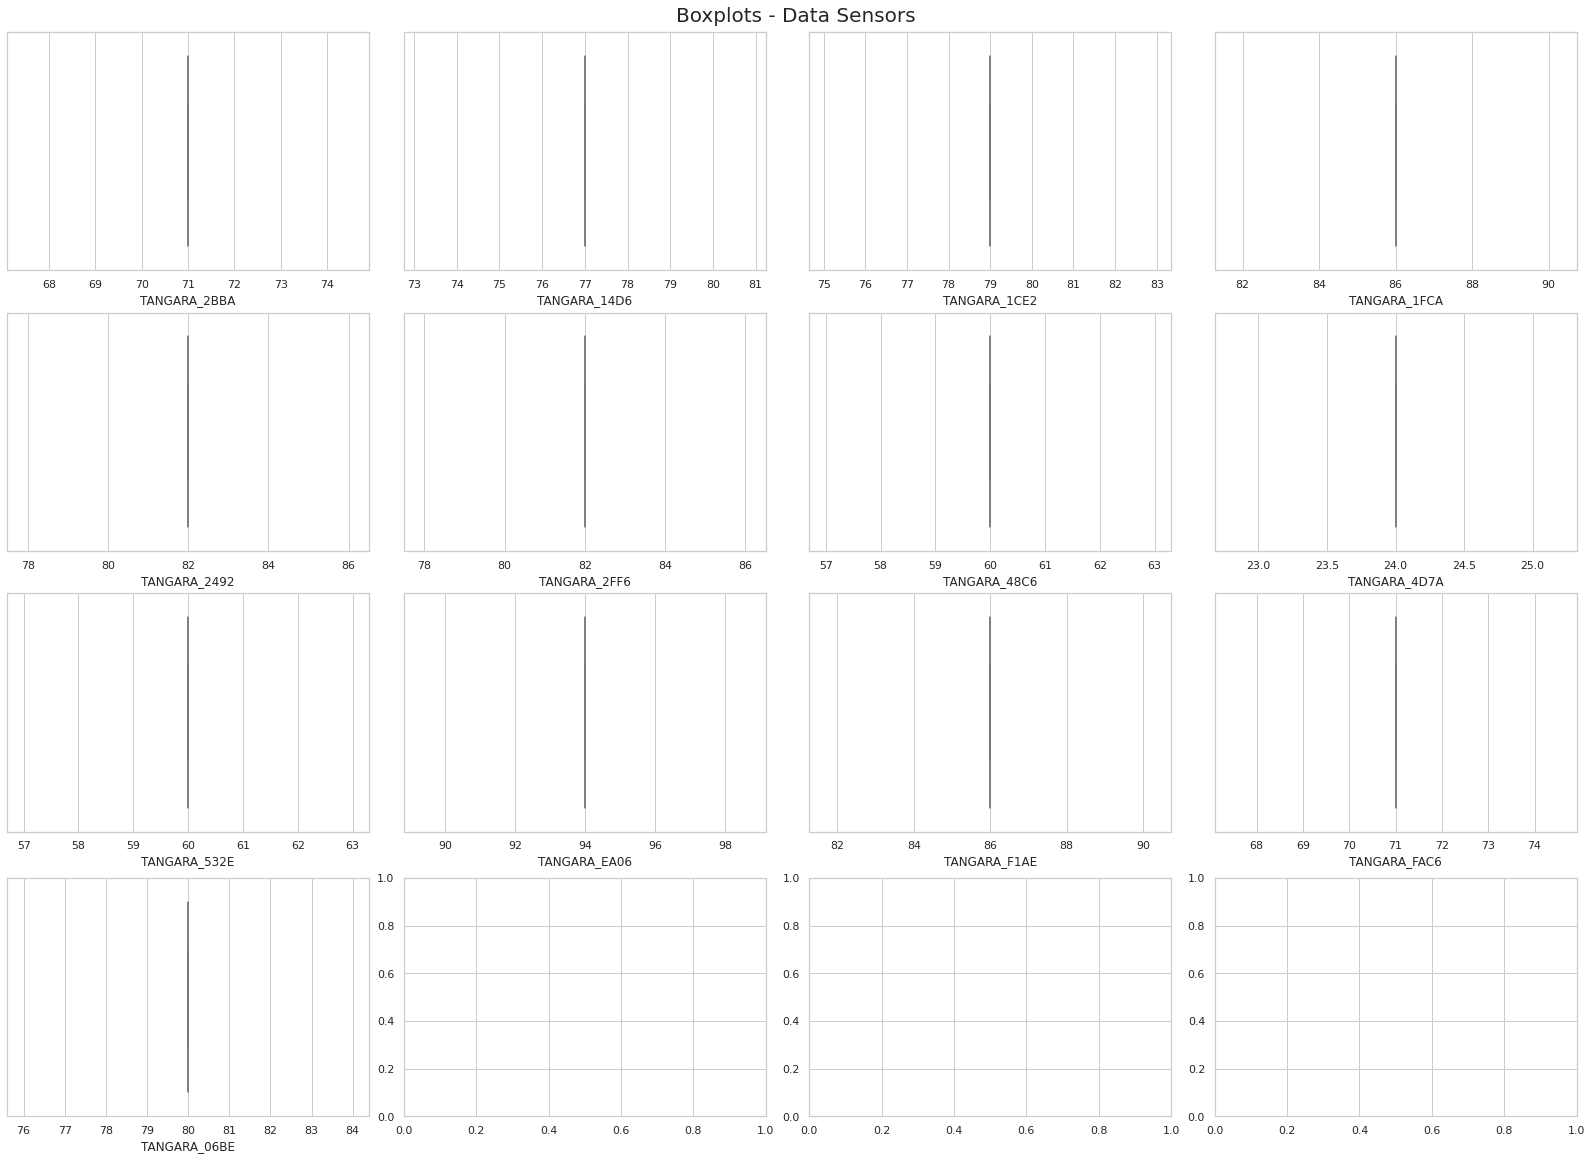

In [51]:
# Plot Boxplots
boxplots(aqi_last_24h)

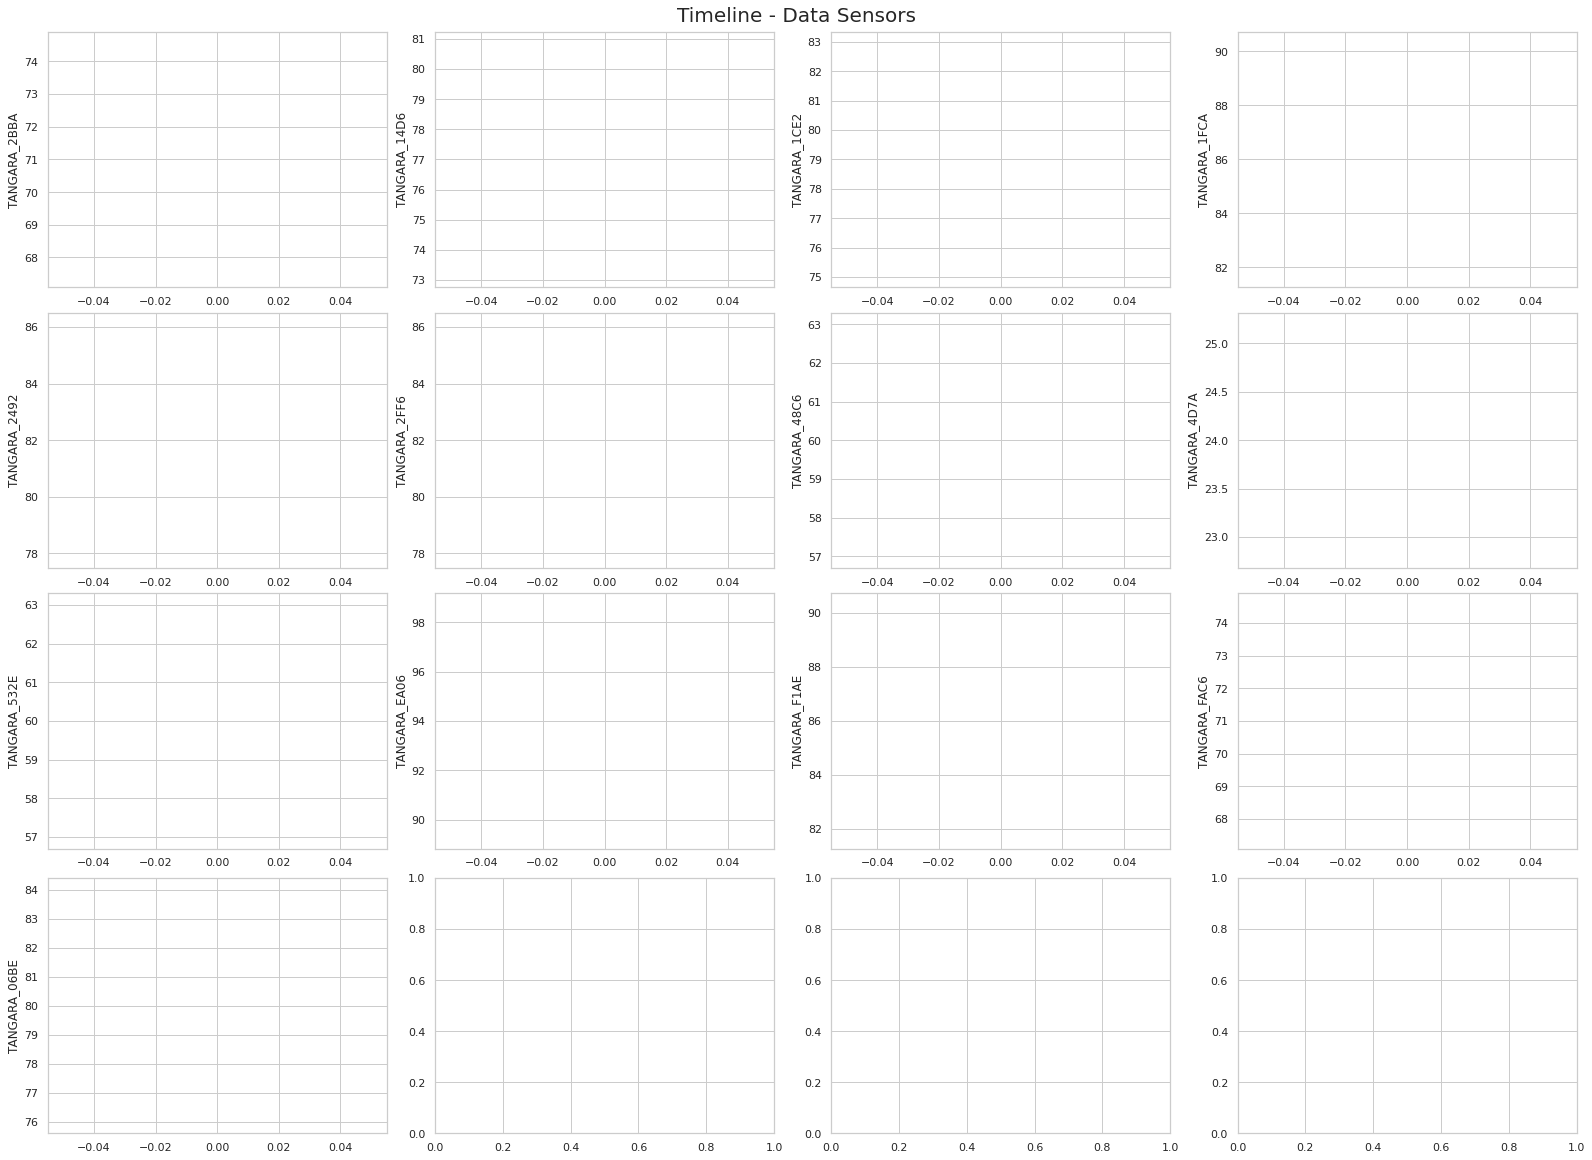

In [52]:
# Plot Lineplots
lineplots(aqi_last_24h)

In [53]:
# Save aqi_last_24h into Catalog
catalog.save('aqi_last_24h', aqi_last_24h)

2022-09-10 15:27:28,539 - kedro.io.data_catalog - INFO - Saving data to `aqi_last_24h` (CSVDataSet)...
